In [9]:
#@title init
import pickle
import torch
import torch.nn.functional as F
import sys
import shutil
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.model_selection import train_test_split
import csv
import numpy as np
import pandas as pd
import PIL.Image
from PIL import Image, ImageDraw
import IPython.display
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from ipywidgets import interact, Button, FloatSlider, Layout
import sys

import io
import os, time
import pickle
import shutil
import numpy as np
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import copy
import unicodedata
import re
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from time import perf_counter

# df = pd.read_hdf('coords_wlosses.h5')
#   
df = pd.read_csv('/Users/adamsobieszek/PycharmProjects/psychGAN/content/coords_wlosses.csv')

In [10]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torchvision.transforms import Compose, Resize
import torchvision.transforms.functional as TF
from typing import List, Dict, Union, Tuple
%cd /Users/adamsobieszek/PycharmProjects/_manipy/
# Assuming the existence of these from a library like torchdyn
from manipy.models.flow_models import VectorFieldTransformer, RatingODE
from manipy.models.layers import EnsembleRegressor, MeanRegressor
from manipy.models.rating_models import AlphaBetaRegressor
import pickle
import sys

final_models_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/content/"
device = torch.device('mps')

# del control_models
if not "control_models" in dir():
  # if not os.path.exists("final_models.zip"):
  #   !gdown 1pPjOd-mx-d-vOw1QR_lpJoJmLAGdkI3W
  #   !unzip final_models.zip
  #   !unzip final_models.zip
  control_names = ['happy', 'gender', 'age', 'black', 'trustworthy','attractive','smart']
  control_models = [EnsembleRegressor([MeanRegressor(512,1) for _ in range(8)], model_kwargs={}).to(device) for label in control_names]
  for m,l in zip(control_models,control_names):
    m.load_state_dict(torch.load(f"{final_models_path}/final_models/ensemble_{l}.pt", map_location=torch.device("mps")))
    m.eval()
  ALL_MODELS = {**{l:m for l,m in zip(control_names,control_models)}}


# G, face_w, device = setup_stylegan()

sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)

# Compute the average latent vector
all_z = torch.randn([1, G.mapping.z_dim], device=device)
face_w = G.mapping(all_z, None, truncation_psi=0.5)

sys.path.append('/Users/adamsobieszek/PycharmProjects/_manipy/manipy')
from data.load_datasets import prepare_data2, load_psychGAN_data
from stylegan.utils import sample_w, show_faces, G_context



with G_context(G):
  sample_w(1, truncation_psi=1)
dim = "trustworthy"

# models = [AlphaBetaRegressor(dim=512).to(device) for i in range(8)]
# for i,m in enumerate([torch.load(f"/Users/adamsobieszek/PycharmProjects/psychGAN/best_models/{mm}",map_location=device) for mm in [f"model_{dim}_v{3+i}.pt" for i in range(8)]]):
#     models[i].load_state_dict(m)
#     models[i].eval()
# model = EnsembleRegressor(models)


/Users/adamsobieszek/PycharmProjects/_manipy


In [11]:


def cpu_numpy(*args):
    return tuple([a.detach().cpu().numpy() for a in args]) if len(args)>1 else args[0].detach().cpu().numpy()
def tensor_dd(*args):
    return tuple([torch.tensor(a, dtype=torch.float32).to(device) for a in args]) if len(args)>1 else torch.tensor(args[0], dtype=torch.float32).to(device)

X, y, weights, imgs = prepare_data2({'data':{'attribute_dim':'trustworthy'}},return_imgs=True)
imgs_0_to_1005 = [f"{i}.jpg" for i in range(1005)]
# imgs = [i for i in imgs if "_level" not in i and i not in imgs_0_to_1005 and "_our" not in i and "peterson" not in i]
# imgs = [i for i in imgs if "flow" in i or "_our" in i]
imgs = [i for i in imgs if "peterson" in i or "_vector" in i]
X, y, weights, imgs = prepare_data2({'data':{'attribute_dim':'trustworthy',"imgs":imgs}},return_imgs=True)
# X = X[weights>1]
# y = y[weights>1]
# weights = weights[weights>1]
imgs


preds = ALL_MODELS['trustworthy'](X).squeeze()
preds_np, X_np, y_np, weights_np = cpu_numpy(preds, X, y, weights)
# calculate weighted spearmanr coef between predicted ratings and true ratings
from scipy.stats import spearmanr, pearsonr
spearmanr(preds_np, np.nanmean(y_np,axis=1))[0], pearsonr(preds_np, np.nanmean(y_np,axis=1))[0]  










                              

(np.float64(0.42073292746600416), np.float32(0.43177754))

In [12]:

from manipy.models.rating_models import load_trust_model_ensemble # To load pre-trained trust model




config = {
        # --- Environment & Paths ---
        'DEVICE': 'mps',
        'TARGET_DIMENSION': 'trustworthy', 
        'CHECKPOINT_DIR': '/Users/adamsobieszek/PycharmProjects/psychGAN/best_models/',
        # --- Models ---
        'TRUST_MODEL_ENSEMBLE_SIZE': 8,
        'FLOW_MODEL_DIM': 512,
        'FLOW_MODEL_DEPTH': 4,
        'FLOW_MODEL_NUM_HEADS': 6,
        'FLOW_MODEL_DIM_HEAD': 32,
        'FLOW_MODEL_NUM_REGISTERS': 16,
        'FLOW_MODEL_DROPOUT': 0.1,
        'FLOW_MODEL_CONDITION_DIM': 512,
        'FLOW_MODEL_ADD_RATING_GRADIENT': True,
        'FLOW_MODEL_SIGMOID_ON_RATING': False,
        'FLOW_MODEL_ORTHOGONAL_GRADIENT_PROJECTION': False,
        'BATCH_AVERAGING_SIGMA': 0.015,
        
    }

torch.mps.empty_cache()

def get_trust_model_fn(config, device):
    """
    Loads the trust model and returns a simple function for its forward pass.
    This function will serve as our f(x).
    """
    print("Loading pre-trained trust model to be used as f(w)...")
    trust_model = load_trust_model_ensemble(
        dim_name=config['TARGET_DIMENSION'],
        ensemble_size=config['TRUST_MODEL_ENSEMBLE_SIZE'],
        checkpoint_dir=config.get('CHECKPOINT_DIR', 'best_models'),
        device=device
    )
    trust_model.eval()

    
    # Define the function f(w) using the loaded model
    f_func = lambda w: trust_model(w, output='logit').squeeze(-1) #, output='logit'
    
    
    return f_func, trust_model

    
class f_module(torch.nn.Module):
    def __init__(self, f_potential_func_ref, kwargs={}):
        super(f_module, self).__init__()
        self.f_potential_func = f_potential_func_ref
        self.kwargs = kwargs
    def forward(self, x):
        return self.f_potential_func(x, **self.kwargs)
X_full = sample_w(1000,1,device=config['DEVICE'],_G=G)

if isinstance(X_full, torch.Tensor):
    X_full = X_full.cpu().numpy()
cov_matrix = np.cov(X_full, rowvar=False)


f_func, trust_model_for_conditioning = get_trust_model_fn(config, 'mps')
model = f_module(f_func)
model = model.to(config['DEVICE'])
trust_model_for_conditioning


Loading pre-trained trust model to be used as f(w)...
Loading trust model ensemble for dimension: trustworthy


AlphaBetaRegressor(
  (network): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=1024, out_features=2048, bias=True)
    (8): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=2048, out_features=512, bias=True)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=512, bias=True)
  )
  (head): Sequential(
    (0): Linear(in_features=512, out_features=2, bias=True)
  )
  (output_activation): Exponent()
)

Using Apple Silicon (MPS) backend.
Running 10 simulations on mps...


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


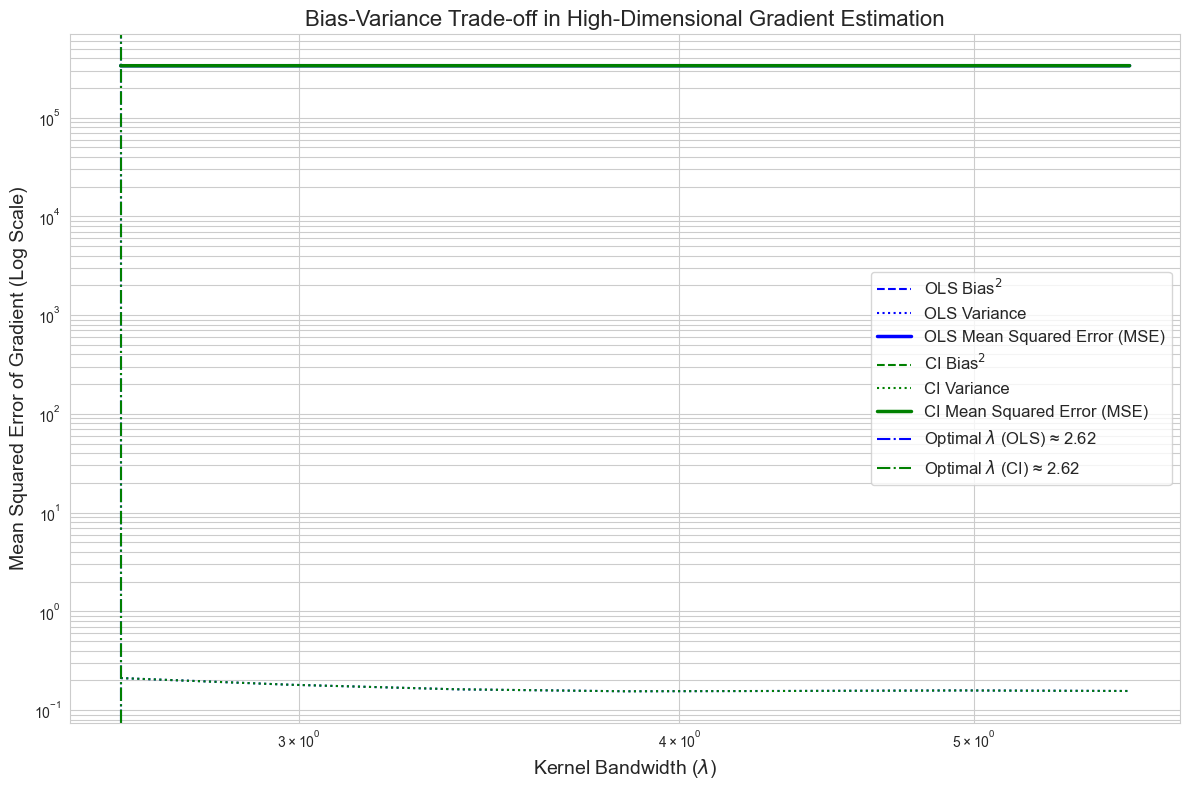

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

# --- 1. Simulation Setup & Ground Truth (Multi-dimensional) ---

# Check for Apple Silicon (MPS) or CUDA availability for parallel computation
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon (MPS) backend.")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA backend.")
else:
    DEVICE = torch.device("cpu")
    print("MPS/CUDA not available. Using CPU.")

# --- Hyperparameters ---
D_DIMS = 40  # Dimensionality of the stimulus space
H_DIMS = 8   # Hidden layer size for the random potential function

def get_randomized_psi():
    """Returns a new potential function using a random 2-layer MLP."""
    direction1, direction2 = torch.randn(D_DIMS, device=DEVICE)*3, torch.randn(D_DIMS, device=DEVICE)
    model = lambda x: direction1 @ x.T + (direction2 @ x.T)**3/3 +torch.randn(1, device=DEVICE)/10
    # No training, just use the random initialization
    
    def psi_torch(s_tensor):
        return model(s_tensor).squeeze(-1)
    
    return psi_torch
@torch.enable_grad()
def grad_psi_torch(psi_func, s_tensor):
    """Calculates the true gradient of a given psi function using autograd."""
    s_tensor.requires_grad_(True)
    psi_val = psi_func(s_tensor)
    
    grad_output = torch.autograd.grad(
        outputs=psi_val, 
        inputs=s_tensor, 
        grad_outputs=torch.ones_like(psi_val)
    )[0]
    return grad_output

@torch.no_grad()
def generate_data(psi_func, n_samples=500):
    """Generates a dataset of stimuli and their true (noiseless) ratings."""
    # Sample stimuli from a standard multivariate normal distribution
    s_data_tensor = torch.randn(n_samples, D_DIMS, device=DEVICE)
    true_ratings = psi_func(s_data_tensor)
    return s_data_tensor, true_ratings

# --- 2. Vectorized Local Estimator Functions (Multi-dimensional) ---

@torch.no_grad()
def gaussian_kernel_torch(u_sq):
    """Standard Gaussian kernel from squared distances."""
    return (1.0 / np.sqrt(2 * np.pi)) * torch.exp(-0.5 * u_sq)

@torch.no_grad()
def estimate_local_ols_torch(s_grid_tensor, s_data_tensor, r_data_tensor, lambda_bw):
    """Estimates local gradients for all s_grid points in parallel."""
    n_grid = s_grid_tensor.shape[0]
    
    # Use broadcasting to calculate all squared distances and weights at once
    dist_sq = torch.cdist(s_grid_tensor, s_data_tensor, p=2)**2
    weights = gaussian_kernel_torch(dist_sq / (lambda_bw**2)) # shape: [n_grid, n_samples]

    # Prepare for batched WLS
    X_aug = torch.cat([torch.ones(s_data_tensor.shape[0], 1, device=DEVICE), s_data_tensor], dim=1)
    
    # Use einsum for efficient batched matrix multiplication
    # XTWX = sum_n w_gn * x_ni * x_nj -> gij
    XTWX = torch.einsum('gn,ni,nj->gij', weights, X_aug, X_aug)
    # XTWy = sum_n w_gn * x_ni * y_n -> gi
    XTWy = torch.einsum('gn,ni,n->gi', weights, X_aug, r_data_tensor)

    # Add regularization for stability and solve in a batch
    regularizer = 1e-6 * torch.eye(D_DIMS + 1, device=DEVICE).unsqueeze(0)
    betas = torch.linalg.solve(XTWX + regularizer, XTWy)
    
    return betas[:, 1:] # Return only the gradient part, ignore intercept

def estimate_local_ci_torch(s_center, s_data_tensor, r_data_tensor, lambda_bw, n_pairs=500):
    """Estimates the local gradient using the Classification Image method."""
    dist_sq_from_center = torch.sum((s_data_tensor - s_center)**2, dim=1)
    local_mask = dist_sq_from_center < (3 * lambda_bw)**2
    
    if local_mask.sum() < 20:
        return torch.full((D_DIMS,), float('nan'), device=DEVICE)

    local_s = s_data_tensor[local_mask]
    local_r = r_data_tensor[local_mask]

    n_local = local_s.shape[0]
    pair_indices_a = torch.randint(0, n_local, (n_pairs,), device=DEVICE)
    pair_indices_b = torch.randint(0, n_local, (n_pairs,), device=DEVICE)

    s_a, r_a = local_s[pair_indices_a], local_r[pair_indices_a]
    s_b, r_b = local_s[pair_indices_b], local_r[pair_indices_b]

    choices = torch.sign(r_a - r_b)
    s_diff = s_a - s_b # shape: [n_pairs, D]
    
    # Scale CI to be comparable to a gradient
    # Proportional to Cov(choice, s_diff) / Cov(s_diff, s_diff)
    # which simplifies to E[choice * s_diff] / (0.5 * Var(s_diff))
    ci_raw = torch.mean(choices.unsqueeze(1) * s_diff, dim=0) # shape: [D]
    
    # For isotropic s_diff, Var(s_diff) is a scalar * I
    s_diff_var = torch.mean(torch.var(s_diff, dim=0))
    if s_diff_var < 1e-8:
        return torch.full((D_DIMS,), float('nan'), device=DEVICE)
        
    ci_scaled = ci_raw / (0.5 * s_diff_var)
    return ci_scaled

# --- 3. Main Simulation Loop for Bias-Variance Analysis ---

if __name__ == '__main__':
    # Simulation parameters
    n_simulations = 10
    n_noise_realizations = 50
    lambda_range = np.logspace(-0.3, 0.75, 20)
    s_grid_tensor = torch.randn(1, D_DIMS, device=DEVICE) # 20 random points to test

    results = {
        'ols_bias_sq': torch.zeros(len(lambda_range), device=DEVICE),
        'ols_var': torch.zeros(len(lambda_range), device=DEVICE),
        'ci_bias_sq': torch.zeros(len(lambda_range), device=DEVICE),
        'ci_var': torch.zeros(len(lambda_range), device=DEVICE),
    }

    print(f"Running {n_simulations} simulations on {DEVICE}...")
    for sim_idx in tqdm(range(n_simulations)):
        psi_func = get_randomized_psi()
        s_data, true_r_data = generate_data(psi_func)
        true_gradient_on_grid = grad_psi_torch(psi_func, s_grid_tensor)

        for lam_idx, lambda_bw in enumerate(lambda_range):
            ols_estimates_over_noise = []
            ci_estimates_over_noise = []
            
            for _ in range(n_noise_realizations):
                # Add new noise to the same true ratings
                noisy_r_data = true_r_data + torch.normal(0, 0.01, size=true_r_data.shape, device=DEVICE)
                
                
                # CI still loops over grid points
                ci_estimates = torch.stack([
                    estimate_local_ci_torch(s0, s_data, noisy_r_data, lambda_bw) for s0 in s_grid_tensor
                ])
                ci_estimates_over_noise.append(ci_estimates)
                # OLS is fully vectorized over the grid
                # ols_estimates = estimate_local_ols_torch(s_grid_tensor, s_data, noisy_r_data, lambda_bw)
                ols_estimates_over_noise.append(ci_estimates)#ols_estimates)

            # Stack results from all noise realizations
            ols_stack = torch.stack(ols_estimates_over_noise) # [n_noise, n_grid, D]
            ci_stack = torch.stack(ci_estimates_over_noise)   # [n_noise, n_grid, D]

            # --- Calculate Stats for this simulation run ---
            # OLS
            mean_ols_estimate = torch.mean(ols_stack, dim=0)
            ols_bias_vectors = mean_ols_estimate - true_gradient_on_grid
            ols_bias_sq_per_point = torch.sum(ols_bias_vectors**2, dim=1)
            # Variance is the trace of the covariance matrix of estimates
            ols_var_per_point = torch.sum(torch.var(ols_stack, dim=0), dim=1)
            
            # CI
            mean_ci_estimate = torch.mean(ci_stack, dim=0)
            ci_bias_vectors = mean_ci_estimate - true_gradient_on_grid
            ci_bias_sq_per_point = torch.sum(ci_bias_vectors**2, dim=1)
            ci_var_per_point = torch.sum(torch.var(ci_stack, dim=0), dim=1)
            
            # Average over the grid points and add to total
            results['ols_bias_sq'][lam_idx] += torch.nanmean(ols_bias_sq_per_point)
            results['ols_var'][lam_idx] += torch.nanmean(ols_var_per_point)
            results['ci_bias_sq'][lam_idx] += torch.nanmean(ci_bias_sq_per_point)
            results['ci_var'][lam_idx] += torch.nanmean(ci_var_per_point)

    # --- 4. Aggregate and Plot Results ---
    # Average over all simulations
    results_cpu = {k: (v / n_simulations).cpu().numpy() for k, v in results.items()}
    
    mse_ols = results_cpu['ols_bias_sq'] + results_cpu['ols_var']
    mse_ci = results_cpu['ci_bias_sq'] + results_cpu['ci_var']

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(lambda_range, results_cpu['ols_bias_sq'], 'b--', label='OLS Bias$^2$')
    ax.plot(lambda_range, results_cpu['ols_var'], 'b:', label='OLS Variance')
    ax.plot(lambda_range, mse_ols, 'b-', lw=2.5, label='OLS Mean Squared Error (MSE)')
    
    ax.plot(lambda_range, results_cpu['ci_bias_sq'], 'g--', label='CI Bias$^2$')
    ax.plot(lambda_range, results_cpu['ci_var'], 'g:', label='CI Variance')
    ax.plot(lambda_range, mse_ci, 'g-', lw=2.5, label='CI Mean Squared Error (MSE)')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Bias-Variance Trade-off in High-Dimensional Gradient Estimation', fontsize=16)
    ax.set_xlabel('Kernel Bandwidth ($\lambda$)', fontsize=14)
    ax.set_ylabel('Mean Squared Error of Gradient (Log Scale)', fontsize=14)
    ax.grid(True, which="both", ls="-")
    
    # Find and plot the optimal lambda
    opt_lambda_ols = lambda_range[np.nanargmin(mse_ols)]
    opt_lambda_ci = lambda_range[np.nanargmin(mse_ci)]
    ax.axvline(opt_lambda_ols, color='b', linestyle='-.', label=f'Optimal $\lambda$ (OLS) ≈ {opt_lambda_ols:.2f}')
    ax.axvline(opt_lambda_ci, color='g', linestyle='-.', label=f'Optimal $\lambda$ (CI) ≈ {opt_lambda_ci:.2f}')
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

# if __name__ == '__main__':
#     # Simulation parameters
#     n_simulations = 10
#     lambda_range = np.logspace(-1, 0.5, 10) # Range of kernel bandwidths

#     # Store results
#     results = {
#         'ols_bias_sq': np.zeros((n_simulations, len(lambda_range))),
#         'ols_var': np.zeros((n_simulations, len(lambda_range))),
#         'ci_bias_sq': np.zeros((n_simulations, len(lambda_range))),
#         'ci_var': np.zeros((n_simulations, len(lambda_range))),
#     }

#     print(f"Running {n_simulations} simulations...")
#     for sim_idx in tqdm(range(n_simulations)):
#         # Get a new random function and generate data for it
#         s_grid = np.linspace(-4, 4, 10) + np.random.randn(10)*0.1 # Grid of points to evaluate estimators
#         psi_func = get_randomized_psi()
#         s_data, r_data = generate_data(psi_func, n_samples=3000, noise_std=2.0)
#         true_gradient_on_grid = np.array([grad_psi_torch(psi_func, s) for s in s_grid])

#         for lam_idx, lambda_bw in enumerate(lambda_range):
#             # Get estimates for all points on the grid
#             ols_estimates = np.array([estimate_local_ols(s0, s_data, r_data, lambda_bw) for s0 in s_grid])
#             ci_estimates = np.array([estimate_local_ci(s0, s_data, r_data, lambda_bw) for s0 in s_grid])
            
#             # Remove NaNs before calculating stats
#             valid_ols = ~np.isnan(ols_estimates)
#             valid_ci = ~np.isnan(ci_estimates)

#             if np.sum(valid_ols) > 0:
#                 # Calculate errors relative to the true gradient
#                 ols_errors = ols_estimates[valid_ols] - true_gradient_on_grid[valid_ols]
#                 # Bias^2 is the square of the average error
#                 results['ols_bias_sq'][sim_idx, lam_idx] = np.mean(ols_errors)**2
#                 # Variance is the variance of the estimates themselves
#                 results['ols_var'][sim_idx, lam_idx] = np.var(ols_estimates[valid_ols])

#             if np.sum(valid_ci) > 0:
#                 ci_errors = ci_estimates[valid_ci] - true_gradient_on_grid[valid_ci]
#                 results['ci_bias_sq'][sim_idx, lam_idx] = np.mean(ci_errors)**2
#                 results['ci_var'][sim_idx, lam_idx] = np.var(ci_estimates[valid_ci])

#     # --- 4. Aggregate and Plot Results ---
    
#     # Average the results over all simulations
#     mean_ols_bias_sq = np.mean(results['ols_bias_sq'], axis=0)
#     mean_ols_var = np.mean(results['ols_var'], axis=0)
#     mean_ci_bias_sq = np.mean(results['ci_bias_sq'], axis=0)
#     mean_ci_var = np.mean(results['ci_var'], axis=0)
    
#     # Calculate Mean Squared Error (MSE)
#     mse_ols = mean_ols_bias_sq + mean_ols_var
#     mse_ci = mean_ci_bias_sq + mean_ci_var

#     sns.set_style("whitegrid")
#     fig, ax = plt.subplots(figsize=(12, 8))

#     # OLS plots
#     ax.plot(lambda_range, mean_ols_bias_sq, 'b--', label='OLS Bias$^2$')
#     ax.plot(lambda_range, mean_ols_var, 'b:', label='OLS Variance')
#     ax.plot(lambda_range, mse_ols, 'b-', lw=2, label='OLS Mean Squared Error (MSE)')
    
#     # CI plots
#     ax.plot(lambda_range, mean_ci_bias_sq, 'g--', label='CI Bias$^2$')
#     ax.plot(lambda_range, mean_ci_var, 'g:', label='CI Variance')
#     ax.plot(lambda_range, mse_ci, 'g-', lw=2, label='CI Mean Squared Error (MSE)')

#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_title('Bias-Variance Trade-off for Local Gradient Estimators', fontsize=16)
#     ax.set_xlabel('Kernel Bandwidth ($\lambda$)', fontsize=14)
#     ax.set_ylabel('Error (Log Scale)', fontsize=14)
#     ax.legend(fontsize=12)
#     ax.grid(True, which="both", ls="-")
    
#     # Find and plot the optimal lambda for each method
#     opt_lambda_ols = lambda_range[np.argmin(mse_ols)]
#     opt_lambda_ci = lambda_range[np.argmin(mse_ci)]
#     ax.axvline(opt_lambda_ols, color='b', linestyle='-.', label=f'Optimal $\lambda$ (OLS) ≈ {opt_lambda_ols:.2f}')
#     ax.axvline(opt_lambda_ci, color='g', linestyle='-.', label=f'Optimal $\lambda$ (CI) ≈ {opt_lambda_ci:.2f}')
#     ax.legend(fontsize=12) # Re-call legend to include new labels

#     plt.tight_layout()
#     plt.show()


In [15]:
import torch
import torch.nn as nn
from typing import Sequence


LATENT_DIM = 512


# assume ALL_MODELS, G, DEVICE, prepare_data2 are defined

def manip_batch(w, model):
    from torchdiffeq import odeint
    ode_func = lambda t, w: grad(w, model)
    t_span = torch.linspace(0, 2.5, 10, device=device)
    traj_all = odeint(ode_func, w, t_span, method='rk4')
    return traj_all

def grad(w, model, kwargs={}):
    """Computes the gradient of a model's output with respect to the input."""
    w = w.detach().clone().requires_grad_(True)
    output = model(w, **kwargs)
    torch.sum(output).backward()
    return w.grad.detach()


class DirectionBasisNet(nn.Module):
    """Rotation-equivariant predictor.

    Parameters
    ----------
    input_dim  : ambient dimension *p* (size of the latent space)
    n_basis    : number of learnable anchor directions φ_i
    hidden_dims: widths of hidden ReLU layers after the dot-product map
    offset     : constant offset added to the final prediction (≈12 here)
    """

    def __init__(
        self,
        input_dim: int,
        n_basis: int = 64,
        hidden_dims: Sequence[int] | None = (128, 64),
        offset: float = 12.0,
    ) -> None:
        super().__init__()
        # φ_i ~ N(0, I) at init; normalisation done on the fly in forward()
        self.anchor = nn.Parameter(torch.randn(n_basis, input_dim))
        layers: list[nn.Module] = []
        prev = n_basis
        if hidden_dims:
            for h in hidden_dims:
                layers += [nn.Linear(prev, h), nn.ReLU()]
                prev = h
        layers.append(nn.Linear(prev, 1))
        self.mlp = nn.Sequential(*layers)
        self.register_buffer("_offset", torch.tensor(offset))

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # (B, p)
        # Cosine similarities (B, k) after normalising anchors onto S^{p-1}
        anchor_norm = nn.functional.normalize(self.anchor, dim=1, eps=1e-6)
        cos_sim = torch.matmul(x, anchor_norm.T)
        return self.mlp(cos_sim) + self._offset


model = ALL_MODELS["trustworthy"]
net = DirectionBasisNet(LATENT_DIM, n_basis=128).to(DEVICE)
net.load_state_dict(torch.load("predict_end_of_w_dist_on_direction4.pth"))


X, y, weights = prepare_data2({'data':{'attribute_dim':'trustworthy'}})
y = torch.nanmean(y, dim=-1)
# fit linear model to y and X
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X.cpu().numpy(), y.cpu().numpy())
reg.coef_





# fit linear model to y and X

array([-3.21319024e-03,  5.59222233e-03, -6.45687571e-03,  7.30457809e-03,
        4.07741219e-03, -2.68946099e-03, -7.58889131e-03, -3.15466593e-03,
       -7.70760095e-03, -4.60384041e-03,  1.87181141e-02, -3.32554709e-03,
        5.40572964e-03, -1.41410343e-03,  2.63651507e-03, -3.43506515e-04,
       -5.13407309e-03, -6.53449912e-03, -2.35665888e-02,  6.79565594e-03,
       -2.38762517e-03, -5.14266919e-03, -1.37446225e-02, -1.70651078e-03,
       -4.34354693e-03,  1.74289767e-03,  2.70466693e-03,  2.94849207e-03,
        2.73012277e-03, -2.79764039e-03,  1.16047682e-03,  8.36996082e-03,
       -9.67223942e-03, -4.73735621e-03, -3.14401276e-03,  5.83981257e-03,
       -9.27700847e-03, -7.37559423e-03,  6.72545866e-04, -2.36698776e-03,
        1.87236574e-02, -9.53701965e-04,  9.93342977e-03,  4.54470329e-03,
        1.82257630e-02, -7.98336789e-03, -1.26747752e-03, -8.33867118e-04,
       -1.96534256e-03,  6.84973411e-03,  7.02983933e-04,  2.01416109e-02,
        2.86087347e-03,  

In [22]:
import torch, matplotlib.pyplot as plt
from torchdiffeq import odeint           # already in your env
from sklearn.linear_model import LinearRegression, Ridge
import torch

def fit_local_direction(w0: torch.Tensor,
                        lambda_kernel: float,
                        X: torch.Tensor,
                        model: torch.nn.Module,
                        ridge_alpha: float = 0.1):
    """
    Locally-weighted linear and Ridge regressions at point w0.

    Parameters
    ----------
    w0 : (d,) torch.Tensor
        Centre of the kernel.
    lambda_kernel : float
        Gaussian bandwidth.
    X : (n, d) torch.Tensor
        Feature matrix.
    y : (n,) or (n, 1) torch.Tensor
        Target values.
    ridge_alpha : float, optional
        Regularisation strength for Ridge (default 0.1).

    Returns
    -------
    direction : (d,) torch.Tensor
        Coefficients from locally-weighted OLS.
    direction_ridge : (d,) torch.Tensor
        Coefficients from locally-weighted Ridge.
    """
    y = model(X).squeeze(-1)
    # ---------------------------------------------------------
    # 1. Gaussian kernel weights
    # ---------------------------------------------------------
    # sq_dist = ((X - w0) ** 2).sum(dim=-1)                               # (n,)
    # kernel = torch.exp(-sq_dist / (2.0 * lambda_kernel ** 2))           # (n,)
    # kernel_weights = kernel / (kernel.sum() + 1e-12)                    # normalise & avoid /0
    kernel_weights = torch.ones_like(X[:, 0])
    
    # move to CPU / NumPy for scikit-learn
    X_np = X.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy().ravel()
    w_np = kernel_weights.detach().cpu().numpy()

    # ---------------------------------------------------------
    # 2. Locally-weighted OLS
    # ---------------------------------------------------------
    ols = LinearRegression(fit_intercept=True)
    ols.fit(X_np, y_np, sample_weight=w_np)
    direction = torch.as_tensor(ols.coef_, dtype=torch.float32, device=X.device)

    # ---------------------------------------------------------
    # 3. Locally-weighted Ridge
    # ---------------------------------------------------------
    ridge = Ridge(alpha=ridge_alpha, fit_intercept=True)
    ridge.fit(X_np, y_np, sample_weight=w_np)
    direction_ridge = torch.as_tensor(ridge.coef_, dtype=torch.float32, device=X.device)

    return direction, direction_ridge

def get_points_near(w0s, all_ws, num_points=1000):
    """
    For each row in w0s, return the num_points nearest points from all_ws.
    Args:
        w0s: (batch, d) tensor of query points
        all_ws: (N, d) tensor of candidate points
        num_points: int, number of nearest points to select per row
    Returns:
        ws_sorted: (batch, num_points, d) tensor of nearest points for each w0
    """
    # Compute squared distances: (batch, N)
    sq_dist = torch.cdist(w0s, all_ws, p=2)
    # Get indices of nearest points for each row in w0s
    nearest_indices = sq_dist.argsort(dim=1)[:, :num_points]  # (batch, num_points)
    # Gather nearest points for each row
    ws_sorted = all_ws[nearest_indices]  # (batch, num_points, d)
    return ws_sorted

device = torch.device("mps")

# ------------------------------------------------------------------
# 0.  Objects you said already exist
# ------------------------------------------------------------------
# G              : the StyleGAN2 object (with mapping.w_avg)
# ALL_MODELS     : dict of attribute→predictor networks
# DirectionBasisNet, sample_w              (from your snippet)
with G_context(G):
    LATENT_DIM = 512
    model  = ALL_MODELS["trustworthy"].to(device)          # “ground-truth” scorer
    net_ood = DirectionBasisNet(LATENT_DIM, 128).to(device)
    net_ood.load_state_dict(torch.load("predict_end_of_w_dist_on_direction4.pth"))
    net_ood.eval()

    w_avg = G.mapping.w_avg.to(device)

    # ------------------------------------------------------------------
    # 1. Linear direction from a quick OLS fit
    # ------------------------------------------------------------------
    # X, y, _ = prepare_data2({'data': {'attribute_dim': 'trustworthy'}})
    # y = torch.nanmean(y, dim=-1)           # (N,)   ratings 0–100
    # direction /= direction.norm()          # unit

    # ------------------------------------------------------------------
    # 2. Helper: autograd gradient of the predictor wrt latent w
    # ------------------------------------------------------------------
    def grad_fn(w_tensor):
        w = w_tensor.clone().detach().requires_grad_(True)
        model(w).sum().backward()
        return w.grad.detach()

    # ------------------------------------------------------------------
    # 3. Risk per step, based on Eq. (1) in previous message
    # ------------------------------------------------------------------
    def angular_risk(w, dir_vec):
        g  = grad_fn(w)                                   # true slope
        u  = g / (g.norm(dim=-1, keepdim=True) + 1e-9)    # true dir
        dot_product = (u @ dir_vec.T).sum(dim=-1)
        return dot_product
        # here we assume plug-in estimate = g (no extra est noise)
        # ⇒ instantaneous angle-variance part is numerically 0
        return torch.zeros(w.size(0), device=device)      # angular term

    def ood_risk(w):
        norms = (w - w_avg).norm(dim=-1, keepdim=True)
        z = (w - w_avg) / norms
        score = net_ood(z).squeeze(-1)                    # scalar
        return (norms.squeeze(-1)/score).float() * 0.0000000001               # constant penalty

    def total_risk(w, dir_vec):
        return #angular_risk(w, dir_vec) + ood_risk(w)
    
    def mse(w, init_ratings, step):
        return ((model(w).squeeze(-1) - (init_ratings+step))**2)**0.5


    # ------------------------------------------------------------------
    # 4. Monte-Carlo paths along the linear direction
    # ------------------------------------------------------------------
    BATCH       = 10
    STEP        = 1          # latent L2 units
    N_STEPS     = 3
    lengths     = torch.arange(N_STEPS+1, device=device) * STEP

    w0          = sample_w(LATENT_DIM, BATCH).to(device)  # (B, 512)
    w_t     = w0
    w_t_ridge     = w0

    inst_risk   = torch.zeros(BATCH, N_STEPS+1, device=device)  # per-step
    init_mse = torch.zeros(BATCH, N_STEPS+1, device=device)
    init_mse_ridge = torch.zeros(BATCH, N_STEPS+1, device=device)
    init_ratings = model(w0).squeeze(-1)
    init_ratings_ridge = init_ratings


    with torch.no_grad():
        all_ws = sample_w(10000, truncation_psi=1, device=device)
        # fit local direction to each row of ws_sorted


        for i, L in tqdm(enumerate(lengths)):
            ws_for_w_t = get_points_near(w_t, all_ws, num_points=1000)
            ws_for_w_t_ridge = get_points_near(w_t_ridge, all_ws, num_points=1000)
            directions = []
            directions_ridge = []
            for local_w_t, local_ws in zip(w_t, ws_for_w_t):
                direction, direction_ridge = fit_local_direction(local_w_t, 3.0, local_ws, model)
                directions.append(direction)
            for local_w_t_ridge, local_ws_ridge in zip(w_t_ridge, ws_for_w_t_ridge):
                direction_ridge, direction_ridge_ridge = fit_local_direction(local_w_t_ridge, 3.0, local_ws_ridge, model)
                directions_ridge.append(direction_ridge)
            dir_vec = torch.stack(directions).to(device)
            dir_vec_ridge = torch.stack(directions_ridge).to(device)
            dir_vec_ridge /= dir_vec_ridge.norm(dim=-1, keepdim=True)**2
            dir_vec /= dir_vec.norm(dim=-1, keepdim=True)**2

            w_t_ridge = w_t_ridge + L * dir_vec_ridge             # (B, 512)
            w_t = w_t + L * dir_vec
            init_mse_ridge[:, i] = mse(w_t_ridge, init_ratings_ridge, L)
            init_mse[:, i] = mse(w_t, init_ratings, L)
            # inst_risk[:, i] = total_risk(w_t, dir_vec)

    # cum_risk = torch.cumsum(inst_risk[:, 1:], dim=1) * STEP      # ∫ risk ds
    cum_risk = init_mse
    cum_risk_ridge = init_mse_ridge
    # ------------------------------------------------------------------
    # 5. Aggregate & plot
    # ------------------------------------------------------------------
    mean = cum_risk.mean(0).cpu()
    mean_ridge = cum_risk_ridge.mean(0).cpu()
    lo, hi = torch.quantile(cum_risk, torch.tensor([0.05, 0.95], device=device), dim=0).cpu()
    lo_ridge, hi_ridge = torch.quantile(cum_risk_ridge, torch.tensor([0.05, 0.95], device=device), dim=0).cpu()
    plt.figure(figsize=(6,4))
    plt.plot(lengths.detach().cpu(), mean.detach(), label="mean")
    plt.fill_between(lengths.detach().cpu(), lo.detach(), hi.detach(), alpha=.25, label="90% CI")
    plt.xlabel("path length (latent units)"); plt.ylabel("cumulative risk")
    plt.title("Risk accumulation – linear manipulation")
    plt.plot(lengths.detach().cpu(), mean_ridge.detach(), label="Ridge")
    plt.fill_between(lengths.detach().cpu(), lo_ridge.detach(), hi_ridge.detach(), alpha=.25, label="90% CI")


    plt.tight_layout(); plt.legend(); plt.show()

0it [00:37, ?it/s]


RuntimeError: The expanded size of the tensor (10) must match the existing size (512) at non-singleton dimension 0.  Target sizes: [10].  Tensor sizes: [512]

tensor([0.5769, 0.5208], device='mps:0')


Generating plot for 5 different initializations...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x40 and 1x400)

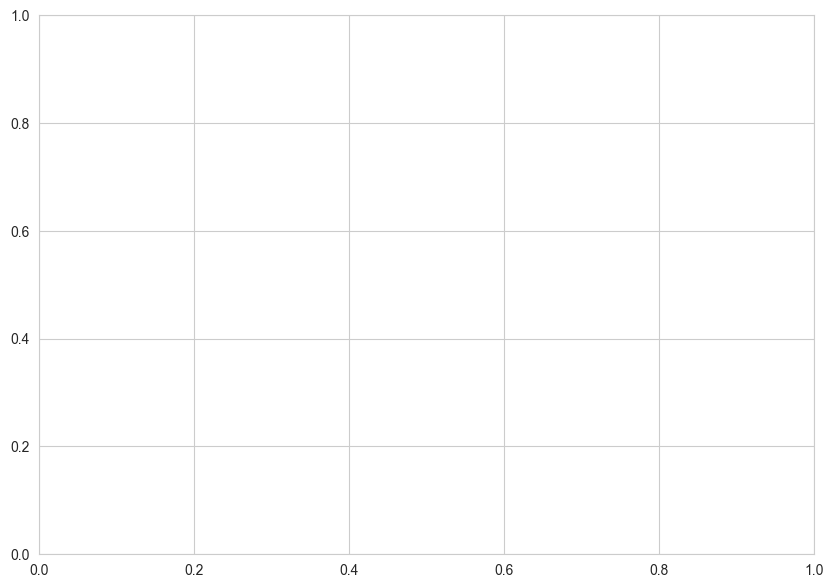

In [ ]:

def plot_psi_1d(num_initializations=5, plot_range=(-5, 5), num_points=400):
    """
    Generates and plots the 1D shape of the psi function for multiple
    random initializations.
    """
    x_tensor = torch.linspace(plot_range[0], plot_range[1], num_points, device=DEVICE).unsqueeze(-1)
    fig, ax = plt.subplots(figsize=(10, 7))

    print(f"Generating plot for {num_initializations} different initializations...")
    for i in range(num_initializations):
        psi = get_randomized_psi()
        with torch.no_grad():
            y_tensor = psi(x_tensor)

        x_plot = x_tensor.cpu().numpy()
        y_plot = y_tensor.cpu().numpy()
        ax.plot(x_plot, y_plot, label=f'Initialization {i+1}', alpha=0.9)

    ax.set_title(f'Shape of KAN-based Potential Function $\psi(s)$ in 1D', fontsize=16)
    ax.set_xlabel('$s$', fontsize=12)
    ax.set_ylabel('$\psi(s)$', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    plt.show()

if __name__ == '__main__':
    plot_psi_1d(num_initializations=5)


Using Apple Silicon (MPS) backend.
Running 5 simulations on mps...


Simulations: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


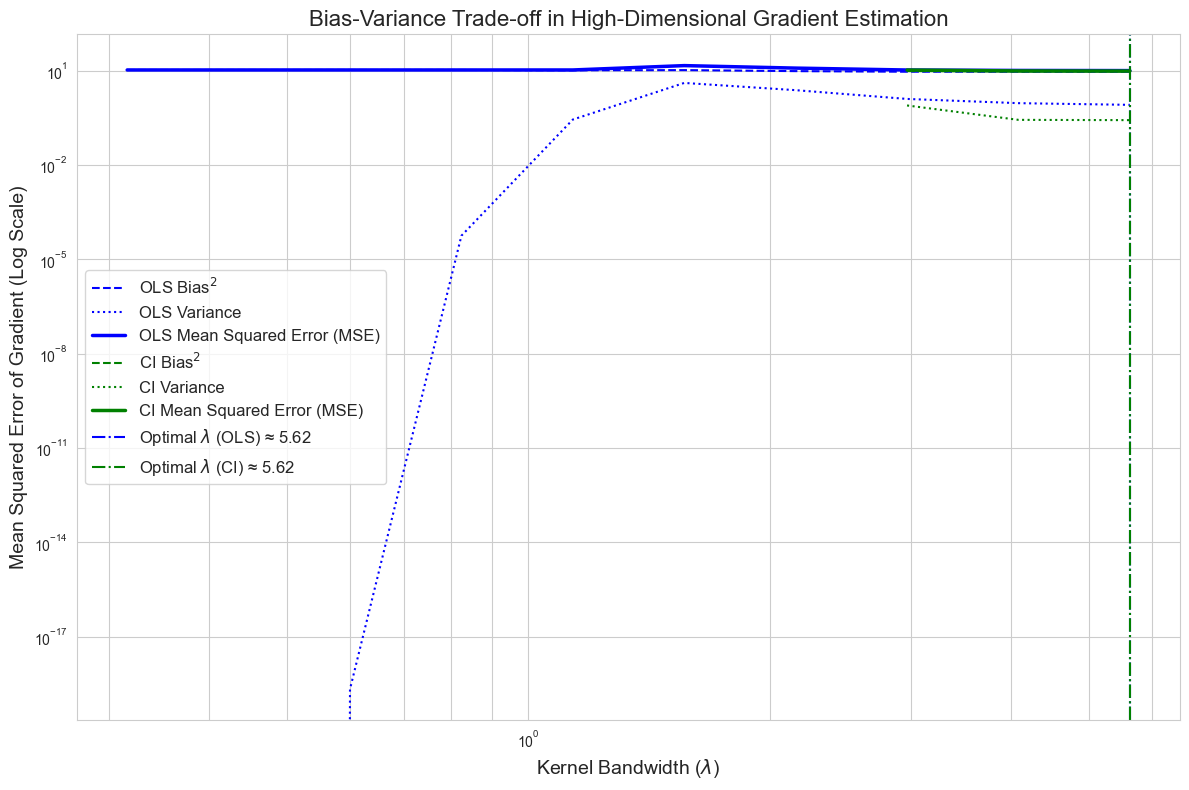

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Simulation Setup & Ground Truth (Multi-dimensional) ---

# Check for Apple Silicon (MPS) or CUDA availability for parallel computation
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon (MPS) backend.")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA backend.")
else:
    DEVICE = torch.device("cpu")
    print("MPS/CUDA not available. Using CPU.")

# --- Hyperparameters ---
D_DIMS = 40  # Dimensionality of the stimulus space

# --- New Psi Function Definition ---

class KANlikeLayer(nn.Module):
    """
    A layer inspired by Kolmogorov-Arnold Networks using Gaussian RBFs.
    """
    def __init__(self, input_dims, grid_size=15, grid_range=(-3, 3)):
        super().__init__()
        self.input_dims = input_dims
        self.grid_size = grid_size

        grid_centers = torch.linspace(grid_range[0], grid_range[1], grid_size, device=DEVICE)
        self.register_buffer("grid_centers", grid_centers.expand(input_dims, -1))

        width = (grid_range[1] - grid_range[0]) / (grid_size - 1) * 1.5
        self.register_buffer("widths", torch.full((input_dims, grid_size), width, device=DEVICE))
        
        # Random coefficients create the random non-linear relationships
        self.coeffs = nn.Parameter(torch.randn(input_dims, grid_size) * 0.3)

    def forward(self, x):
        x = x.unsqueeze(-1)
        phi = torch.exp(-((x - self.grid_centers)**2) / (2 * self.widths**2))
        y_parts = torch.sum(phi * self.coeffs, dim=2)
        return torch.sum(y_parts, dim=1)

class HybridKAN(nn.Module):
    """
    Combines a KAN-like non-linear part with a dominant linear part.
    """
    def __init__(self, input_dims, grid_size=15):
        super().__init__()
        self.kan_part = KANlikeLayer(input_dims=input_dims, grid_size=grid_size)
        self.linear_part = nn.Linear(input_dims, 1)

    def forward(self, x):
        # The final potential is the sum of the linear and non-linear parts
        return self.linear_part(x) + self.kan_part(x).unsqueeze(-1)

def get_randomized_psi():
    """
    Returns a new potential function using a hybrid KAN-like model
    with a parallel linear component.
    """
    model = HybridKAN(input_dims=D_DIMS).to(DEVICE)
    
    def psi_torch(s_tensor):
        return model(s_tensor).squeeze(-1)
            
    return psi_torch
    
# --- Utility Functions (Unchanged) ---

@torch.enable_grad()
def grad_psi_torch(psi_func, s_tensor):
    """Calculates the true gradient of a given psi function using autograd."""
    s_tensor.requires_grad_(True)
    psi_val = psi_func(s_tensor)
    
    grad_output = torch.autograd.grad(
        outputs=psi_val, 
        inputs=s_tensor, 
        grad_outputs=torch.ones_like(psi_val)
    )[0]
    return grad_output

@torch.no_grad()
def generate_data(psi_func, n_samples=5000, noise_std=2.0):
    """Generates a dataset of stimuli and their true (noiseless) ratings."""
    s_data_tensor = torch.randn(n_samples, D_DIMS, device=DEVICE)
    true_ratings = psi_func(s_data_tensor)
    return s_data_tensor, true_ratings

# --- 2. Vectorized Local Estimator Functions (Unchanged) ---

@torch.no_grad()
def gaussian_kernel_torch(u_sq):
    """Standard Gaussian kernel from squared distances."""
    return (1.0 / np.sqrt(2 * np.pi)) * torch.exp(-0.5 * u_sq)

@torch.no_grad()
def estimate_local_ols_torch(s_grid_tensor, s_data_tensor, r_data_tensor, lambda_bw):
    """Estimates local gradients for all s_grid points in parallel."""
    n_grid = s_grid_tensor.shape[0]
    
    dist_sq = torch.cdist(s_grid_tensor, s_data_tensor, p=2)**2
    weights = gaussian_kernel_torch(dist_sq / (lambda_bw**2))

    X_aug = torch.cat([torch.ones(s_data_tensor.shape[0], 1, device=DEVICE), s_data_tensor], dim=1)
    
    XTWX = torch.einsum('gn,ni,nj->gij', weights, X_aug, X_aug)
    XTWy = torch.einsum('gn,ni,n->gi', weights, X_aug, r_data_tensor)

    regularizer = 1e-6 * torch.eye(D_DIMS + 1, device=DEVICE).unsqueeze(0)
    betas = torch.linalg.solve(XTWX + regularizer, XTWy)
    
    return betas[:, 1:]

@torch.no_grad()
def estimate_local_ci_torch(s_center, s_data_tensor, r_data_tensor, lambda_bw, n_pairs=500):
    """Estimates the local gradient using the Classification Image method."""
    dist_sq_from_center = torch.sum((s_data_tensor - s_center)**2, dim=1)
    local_mask = dist_sq_from_center < (3 * lambda_bw)**2
    
    if local_mask.sum() < 20:
        return torch.full((D_DIMS,), float('nan'), device=DEVICE)

    local_s = s_data_tensor[local_mask]
    local_r = r_data_tensor[local_mask]

    n_local = local_s.shape[0]
    pair_indices_a = torch.randint(0, n_local, (n_pairs,), device=DEVICE)
    pair_indices_b = torch.randint(0, n_local, (n_pairs,), device=DEVICE)

    s_a, r_a = local_s[pair_indices_a], local_r[pair_indices_a]
    s_b, r_b = local_s[pair_indices_b], local_r[pair_indices_b]

    choices = torch.sign(r_a - r_b)
    s_diff = s_a - s_b
    
    ci_raw = torch.mean(choices.unsqueeze(1) * s_diff, dim=0)
    
    s_diff_var = torch.mean(torch.var(s_diff, dim=0))
    if s_diff_var < 1e-8:
        return torch.full((D_DIMS,), float('nan'), device=DEVICE)
        
    ci_scaled = ci_raw / (0.5 * s_diff_var)
    return ci_scaled

# --- 3. Main Simulation Loop for Bias-Variance Analysis ---

if __name__ == '__main__':
    # Simulation parameters
    n_simulations = 5
    n_noise_realizations = 20
    lambda_range = np.logspace(-0.5, 0.75, 10)
    s_grid_tensor = torch.randn(10, D_DIMS, device=DEVICE)
    dataset_size = 250

    results = {
        'ols_bias_sq': torch.zeros(len(lambda_range), device=DEVICE),
        'ols_var': torch.zeros(len(lambda_range), device=DEVICE),
        'ci_bias_sq': torch.zeros(len(lambda_range), device=DEVICE),
        'ci_var': torch.zeros(len(lambda_range), device=DEVICE),
    }

    print(f"Running {n_simulations} simulations on {DEVICE}...")
    for sim_idx in tqdm(range(n_simulations), desc="Simulations"):
        # A new random psi function is initialized for each simulation run
        psi_func = get_randomized_psi()
        s_data, true_r_data = generate_data(psi_func, n_samples=dataset_size)
        true_gradient_on_grid = grad_psi_torch(psi_func, s_grid_tensor)

        for lam_idx, lambda_bw in enumerate(lambda_range):
            ols_estimates_over_noise = []
            ci_estimates_over_noise = []
            
            for _ in range(n_noise_realizations):
                noisy_r_data = true_r_data + torch.normal(0, 2.0, size=true_r_data.shape, device=DEVICE)
                
                ols_estimates = estimate_local_ols_torch(s_grid_tensor, s_data, noisy_r_data, lambda_bw)
                ols_estimates_over_noise.append(ols_estimates)
                
                ci_estimates = torch.stack([
                    estimate_local_ci_torch(s0, s_data, noisy_r_data, lambda_bw) for s0 in s_grid_tensor
                ])
                ci_estimates_over_noise.append(ci_estimates)

            ols_stack = torch.stack(ols_estimates_over_noise)
            ci_stack = torch.stack(ci_estimates_over_noise)

            mean_ols_estimate = torch.mean(ols_stack, dim=0)
            ols_bias_sq_per_point = torch.sum((mean_ols_estimate - true_gradient_on_grid)**2, dim=1)
            ols_var_per_point = torch.sum(torch.var(ols_stack, dim=0), dim=1)
            
            mean_ci_estimate = torch.nanmean(ci_stack, dim=0)
            ci_bias_sq_per_point = torch.sum((mean_ci_estimate - true_gradient_on_grid)**2, dim=1)
            ci_var_per_point = torch.sum(torch.var(ci_stack, dim=0), dim=1)
            
            results['ols_bias_sq'][lam_idx] += torch.nanmean(ols_bias_sq_per_point)
            results['ols_var'][lam_idx] += torch.nanmean(ols_var_per_point)
            results['ci_bias_sq'][lam_idx] += torch.nanmean(ci_bias_sq_per_point)
            results['ci_var'][lam_idx] += torch.nanmean(ci_var_per_point)

    # --- 4. Aggregate and Plot Results (Unchanged) ---
    results_cpu = {k: (v / n_simulations).cpu().numpy() for k, v in results.items()}
    
    mse_ols = results_cpu['ols_bias_sq'] + results_cpu['ols_var']
    mse_ci = results_cpu['ci_bias_sq'] + results_cpu['ci_var']

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(lambda_range, results_cpu['ols_bias_sq'], 'b--', label='OLS Bias$^2$')
    ax.plot(lambda_range, results_cpu['ols_var'], 'b:', label='OLS Variance')
    ax.plot(lambda_range, mse_ols, 'b-', lw=2.5, label='OLS Mean Squared Error (MSE)')
    
    ax.plot(lambda_range, results_cpu['ci_bias_sq'], 'g--', label='CI Bias$^2$')
    ax.plot(lambda_range, results_cpu['ci_var'], 'g:', label='CI Variance')
    ax.plot(lambda_range, mse_ci, 'g-', lw=2.5, label='CI Mean Squared Error (MSE)')

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_title('Bias-Variance Trade-off in High-Dimensional Gradient Estimation', fontsize=16)
    ax.set_xlabel('Kernel Bandwidth ($\lambda$)', fontsize=14)
    ax.set_ylabel('Mean Squared Error of Gradient (Log Scale)', fontsize=14)
    ax.grid(True, which="both", ls="-")
    
    opt_lambda_ols = lambda_range[np.nanargmin(mse_ols)]
    opt_lambda_ci = lambda_range[np.nanargmin(mse_ci)]
    ax.axvline(opt_lambda_ols, color='b', linestyle='-.', label=f'Optimal $\lambda$ (OLS) ≈ {opt_lambda_ols:.2f}')
    ax.axvline(opt_lambda_ci, color='g', linestyle='-.', label=f'Optimal $\lambda$ (CI) ≈ {opt_lambda_ci:.2f}')
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (40,) and (1,)

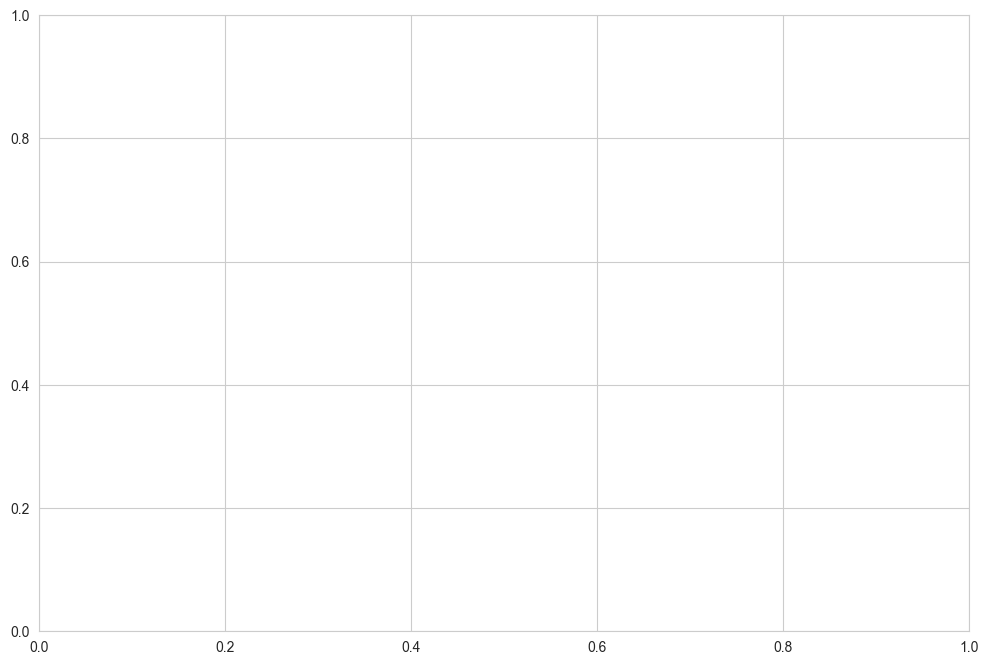

In [ ]:

# --- 4. Aggregate and Plot Results (move to CPU for plotting) ---

mean_ols_bias_sq = np.mean(results_cpu['ols_bias_sq'], axis=0)
mean_ols_var = np.mean(results_cpu['ols_var'], axis=0)
mean_ci_bias_sq = np.mean(results_cpu['ci_bias_sq'], axis=0)
mean_ci_var = np.mean(results_cpu['ci_var'], axis=0)

mse_ols = mean_ols_bias_sq + mean_ols_var
mse_ci = mean_ci_bias_sq + mean_ci_var

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(lambda_range, mean_ols_bias_sq, 'b--', label='OLS Bias$^2$')
ax.plot(lambda_range, mean_ols_var, 'b:', label='OLS Variance')
ax.plot(lambda_range, mse_ols, 'b-', lw=2, label='OLS Mean Squared Error (MSE)')

ax.plot(lambda_range, mean_ci_bias_sq, 'g--', label='CI Bias$^2$')
ax.plot(lambda_range, mean_ci_var, 'g:', label='CI Variance')
ax.plot(lambda_range, mse_ci, 'g-', lw=2, label='CI Mean Squared Error (MSE)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Bias-Variance Trade-off for Local Gradient Estimators', fontsize=16)
ax.set_xlabel('Kernel Bandwidth ($\lambda$)', fontsize=14)
ax.set_ylabel('Error (Log Scale)', fontsize=14)
ax.grid(True, which="both", ls="-")

# Find and plot the optimal lambda
# Add a small epsilon to avoid issues with zero variance/bias at high lambda
opt_lambda_ols = lambda_range[np.nanargmin(mse_ols)]
opt_lambda_ci = lambda_range[np.nanargmin(mse_ci)]
ax.axvline(opt_lambda_ols, color='b', linestyle='-.', label=f'Optimal $\lambda$ (OLS) ≈ {opt_lambda_ols:.2f}')
ax.axvline(opt_lambda_ci, color='g', linestyle='-.', label=f'Optimal $\lambda$ (CI) ≈ {opt_lambda_ci:.2f}')
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:

with torch.no_grad():
    photo_to_coords, dim_to_photo_to_ratings = load_psychGAN_data()

    X, y, weights = prepare_data2({'data':{'attribute_dim':'trustworthy','imgs':[f'{i}.jpg' for i in range(1,1005)]}})
    X_age, y_age, weights_age = prepare_data2({'data':{'attribute_dim':'age','imgs':[f'{i}.jpg' for i in range(1,1005)]}})
    X_happy, y_happy, weights_happy = prepare_data2({'data':{'attribute_dim':'happy','imgs':[f'{i}.jpg' for i in range(1,1005)]}})
    X_gender, y_gender, weights_gender = prepare_data2({'data':{'attribute_dim':'gender','imgs':[f'{i}.jpg' for i in range(1,1005)]}})
    y = torch.nanmean(y, dim=1)
    y_age = torch.nanmean(y_age, dim=1)
    y_happy = torch.nanmean(y_happy, dim=1)
    y_gender = torch.nanmean(y_gender, dim=1)
    y =torch.logit(y)
    X, y, weights = cpu_numpy(X, y, weights)
    X_age, y_age, weights_age = cpu_numpy(X_age, y_age, weights_age)
    X_happy, y_happy, weights_happy = cpu_numpy(X_happy, y_happy, weights_happy)
    X_gender, y_gender, weights_gender = cpu_numpy(X_gender, y_gender, weights_gender)

    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression, Ridge

    cov_matrix = np.cov(X, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    cov_tensor = torch.tensor(cov_matrix, dtype=torch.float32)

    pca = PCA(n_components=min(100, X.shape[1])).fit(X)

    # reconstruct cov_matrix from pca
    cov_matrix_pca = pca.get_covariance()
    inv_cov_matrix_pca = np.linalg.inv(cov_matrix_pca+np.eye(cov_matrix_pca.shape[0])*1e-6)
    cov_matrix_pca = torch.tensor(cov_matrix_pca, dtype=torch.float32)
    cov_matrix_pca = cov_matrix_pca.to(device)
    inv_cov_matrix_pca = torch.tensor(inv_cov_matrix_pca, dtype=torch.float32)
    inv_cov_matrix_pca = inv_cov_matrix_pca.to(device)

    def grad_ci(X, y, cov_matrix, name:str, L2_penalty:float=0):
        if L2_penalty>0:
            gradient = Ridge(alpha=L2_penalty).fit(X, -y).coef_
        else:   
            gradient = LinearRegression().fit(X, -y).coef_
        CI =  gradient.T @ cov_matrix
        inv_CI = gradient.T @ inv_cov_matrix
        gradient, CI, inv_CI = tensor_dd(gradient, CI, inv_CI)
        return {f"{name}_gradient": gradient, f"{name}_CI": CI, f"{name}_inv_CI": inv_CI}
    
    trust_dict = grad_ci(X, y, cov_matrix, "trust")
    age_dict = grad_ci(X_age, y_age, cov_matrix, "age")
    happy_dict = grad_ci(X_happy, y_happy, cov_matrix, "happy")
    gender_dict = grad_ci(X_gender, y_gender, cov_matrix, "gender")

    X = tensor_dd(X)
    # X = X-G.mapping.w_avg.cpu().numpy()

    # show_faces(init_w  + CI2*10, _G=G)







In [ ]:
import torch
import plotly.graph_objects as go
import numpy as np

# Assume 'device' is defined in your environment (e.g., 'cuda' or 'cpu')
# For demonstration purposes, we'll define it here.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# --- Original Helper Functions ---
# (No changes needed here)

def _cos(a, b):
    """Calculates the cosine similarity between two tensors."""
    assert isinstance(a, torch.Tensor) and isinstance(b, torch.Tensor), \
        "Inputs must be torch Tensors."
    a, b = a.reshape(-1).to(device), b.reshape(-1).to(device)
    # Handle potential zero-norm case to avoid division by zero
    norm_a = torch.norm(a)
    norm_b = torch.norm(b)
    if norm_a == 0 or norm_b == 0:
        return torch.tensor(0.0, device=device)
    return torch.dot(a, b) / (norm_a * norm_b)

def cosine_similarity_matrix(*args):
    """Computes a matrix of cosine similarities for a sequence of tensors."""
    return torch.tensor([[_cos(a, b) for a in args] for b in args])

# --- New Complex Function for Plotting ---

def plot_cosine_similarity_heatmap(tensors_dict):
    """
    Calculates and plots an interactive cosine similarity heatmap.

    Args:
        tensors_dict (dict): A dictionary where keys are the variable names (str)
                             and values are the corresponding torch.Tensors.
    """
    names = list(tensors_dict.keys())
    tensors = list(tensors_dict.values())

    # 1. Calculate the similarity matrix
    similarity_data = cosine_similarity_matrix(*tensors)
    similarity_data = (similarity_data*100).to(torch.int32).cpu().numpy()
    # 2. Round the data for cleaner display on the heatmap
    display_text = similarity_data

    # 3. Create the heatmap figure
    fig = go.Figure(data=go.Heatmap(
        z=similarity_data,
        x=names,
        y=names,
        hoverongaps=False,
        text=display_text,
        texttemplate="%{text}",
        textfont={"size":10},
        colorscale='Viridis', # You can change the colorscale, e.g., 'Plasma', 'Blues'
        zmin=-100, # Set the color range minimum
        zmax=100  # Set the color range maximum
    ))

    # 4. Update layout for better readability
    fig.update_layout(
        title='Cosine Similarity Matrix',
        xaxis_title='Variables',
        yaxis_title='Variables',
        xaxis=dict(tickangle=-45),
        width=800,
        height=800,
        autosize=False
    )

    # 5. Display the interactive plot
    fig.show()




# Group your tensors and their names into a dictionary
# This makes the code cleaner and less prone to argument order errors.
variables_to_compare = {
    **trust_dict,
    **age_dict,
    **happy_dict,
    **gender_dict,
}
variables_to_compare = {k:v for k,v in variables_to_compare.items() if not k.endswith("_CI")} | trust_dict

# Generate and display the interactive heatmap
plot_cosine_similarity_heatmap(variables_to_compare)

In [ ]:

def grad_ci(X, y, cov_matrix=None, name: str="", L2_penalty: float = 0, anti_L2_penalty: float = 0, anti_l2_n_components = None):
    """
    Calculates a gradient and its corresponding Classification Image (CI)
    and Anti-Classification Image (double-whitened CI).

    Args:
        X (np.ndarray): The stimulus data matrix (n_samples, n_features).
        y (np.ndarray): The response vector (n_samples,).
        cov_matrix (np.ndarray): The stimulus covariance matrix (n_features, n_features).
        name (str): A string name to prefix the output dictionary keys.
        L2_penalty (float): The regularization strength (alpha) for standard Ridge regression.
        anti_L2_penalty (float): The regularization strength (gamma) for the anti-L2 penalty.

    Returns:
        dict: A dictionary containing the gradient, CI, and inverse CI as torch tensors.
    """
    if L2_penalty > 0 and anti_L2_penalty > 0:
        raise ValueError("Cannot apply both L2 and anti-L2 penalties simultaneously.")

    # We fit against -y to match the convention in your original function
    target = -y
    gradient = None
    if cov_matrix is None:
        cov_matrix = np.cov(X, rowvar=False)

    if anti_L2_penalty > 0:
        if anti_l2_n_components is not None:
            pca = PCA(n_components=anti_l2_n_components).fit(X)
            cov_matrix = pca.get_covariance()

        # --- New: Anti-L2 Penalty Implementation ---
        # This solves for β in: (XᵀX + γ(XᵀX)²)β = Xᵀy
        XTX = X.T @ X if anti_l2_n_components is None else cov_matrix
        XTy = X.T @ target
        
        # Construct the matrix A = XᵀX + γ(XᵀX)²
        penalty_matrix = anti_L2_penalty * (XTX @ XTX)
        A = XTX + penalty_matrix
        
        # Solve the system Aβ = Xᵀy for the gradient β
        gradient = np.linalg.solve(A, XTy)

    elif L2_penalty > 0:
        # --- Standard L2 (Ridge) Penalty ---
        gradient = Ridge(alpha=L2_penalty).fit(X, target).coef_

    else:
        # --- No Penalty (OLS) ---
        gradient = LinearRegression().fit(X, target).coef_

    # Ensure gradient is a 1D array
    if gradient.ndim > 1:
        gradient = gradient.flatten()

    # --- Calculate CI and Anti-CI (Double-Whitened CI) ---
    # The CI is the gradient transformed by the data's covariance structure.
    CI = gradient.T @ cov_matrix
    
    # The "inv_CI" or Anti-CI is the gradient transformed by the inverse covariance.
    # This is the "double-whitened" CI when the gradient is the OLS estimate.
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    inv_CI = gradient.T @ inv_cov_matrix
    
    # Convert all results to the desired tensor format
    gradient, CI, inv_CI = tensor_dd(gradient, CI, inv_CI)

    return {
        f"{name}_gradient": gradient,
        f"{name}_CI": CI,
        f"{name}_inv_CI": inv_CI
    }




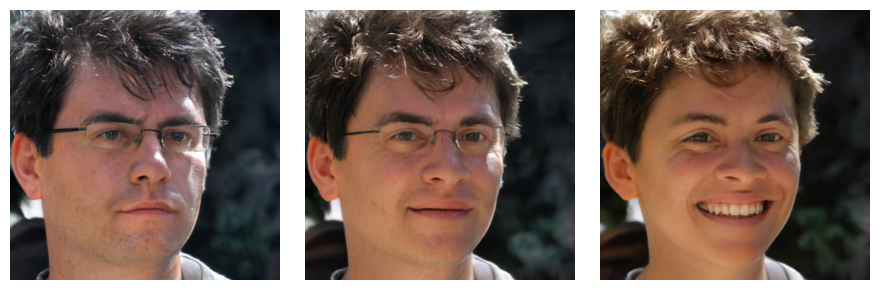

no penalty





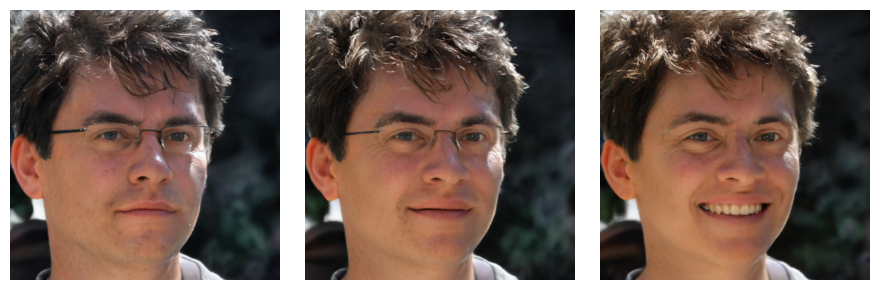

In [ ]:
import numpy as np
import torch
from sklearn.linear_model import Ridge, LinearRegression

# Assume 'tensor_dd' is your helper function for tensor conversion.
def tensor_dd(*args):
    return [torch.from_numpy(np.asarray(arg)).float() for arg in args]


def grad_ci(X, y, cov_matrix=None, name: str='', L2_penalty: float = 0, anti_L2_penalty: float = 0):
    """
    Calculates a gradient and its corresponding Classification Image (CI)
    and Anti-Classification Image, fitting an intercept in all cases.

    Args:
        X (np.ndarray): The stimulus data matrix (uncentered).
        y (np.ndarray): The response vector (uncentered).
        cov_matrix (np.ndarray): The stimulus covariance matrix.
        name (str): A string name to prefix the output dictionary keys.
        L2_penalty (float): The regularization strength for Ridge regression.
        anti_L2_penalty (float): The regularization strength for the anti-L2 penalty.

    Returns:
        dict: A dictionary containing the gradient, CI, and inverse CI.
    """
    if L2_penalty > 0 and anti_L2_penalty > 0:
        raise ValueError("Cannot apply both L2 and anti-L2 penalties simultaneously.")

    # We fit against -y to match the convention in your original function
    target = y
    gradient = None
    if cov_matrix is None:
        cov_matrix = np.cov(X, rowvar=False)

    if anti_L2_penalty > 0:
        # --- New: Anti-L2 Penalty with Intercept ---
        n_samples, n_features = X.shape
        
        # 1. Augment X with a column of ones for the intercept
        X_aug = np.hstack([X, np.ones((n_samples, 1))])
        
        # 2. Construct the penalty matrix that only affects the feature
        #    coefficients, not the intercept.
        #    The penalty is γ * (XᵀX)², applied to the top-left block.
        P = np.zeros((n_features + 1, n_features + 1))
        XTX = X.T @ X
        penalty_core = anti_L2_penalty * (XTX @ XTX)
        P[:n_features, :n_features] = penalty_core

        # 3. Solve the augmented system: (X_augᵀX_aug + P)β_aug = X_augᵀy
        A = (X_aug.T @ X_aug) + P
        b = X_aug.T @ target
        solution_aug = np.linalg.solve(A, b)
        
        # 4. The gradient is the first n_features coefficients
        gradient = solution_aug[:-1]

    elif L2_penalty > 0:
        # --- Standard L2 (Ridge) Penalty, with intercept ---
        model = Ridge(alpha=L2_penalty, fit_intercept=True).fit(X, target)
        gradient = model.coef_

    else:
        # --- No Penalty (OLS), with intercept ---
        model = LinearRegression(fit_intercept=True).fit(X, target)
        gradient = model.coef_

    # Ensure gradient is a 1D array
    if gradient.ndim > 1:
        gradient = gradient.flatten()

    # --- Calculate CI and Anti-CI ---
    CI = gradient.T @ cov_matrix
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    inv_CI = gradient.T @ inv_cov_matrix
    
    gradient, CI, inv_CI = tensor_dd(gradient, CI, inv_CI)

    return {
        f"{name}_gradient": gradient,
        f"{name}_CI": CI,
        f"{name}_inv_CI": inv_CI
    }

def find_orthogonal_gradient(X, y, L2_penalty: float, anti_L2_penalty: float, name: str = "orthogonal"):
    """
    Finds the portion of the OLS gradient that is orthogonal to both the
    Ridge-regularized and anti-L2-regularized gradients.

    Args:
        X (np.ndarray): The stimulus data matrix.
        y (np.ndarray): The response vector.
        L2_penalty (float): The regularization strength for Ridge regression.
        anti_L2_penalty (float): The regularization strength for the anti-L2 penalty.
        name (str): A name for the resulting orthogonal vector.

    Returns:
        dict: A dictionary containing the final orthogonal gradient vector.
    """
    if L2_penalty <= 0 or anti_L2_penalty <= 0:
        raise ValueError("Both L2_penalty and anti_L2_penalty must be greater than 0.")

    cov_matrix = np.cov(X, rowvar=False)

    # 1. Calculate the three necessary gradients
    ols_grad_dict = grad_ci(X, y, cov_matrix, name="ols")
    ridge_grad_dict = grad_ci(X, y, cov_matrix, name="ridge", L2_penalty=L2_penalty)
    anti_l2_grad_dict = grad_ci(X, y, cov_matrix, name="anti_l2", anti_L2_penalty=anti_L2_penalty)

    # Extract the numpy arrays from the tensors for calculation
    beta_ols = ols_grad_dict["ols_gradient"].numpy()
    beta_ridge = ridge_grad_dict["ridge_gradient"].numpy()
    beta_anti = anti_l2_grad_dict["anti_l2_gradient"].numpy()

    # --- Vector Projection Logic ---
    def project(u, v):
        """Projects vector u onto vector v."""
        # Handle potential zero vector to avoid division by zero
        v_norm_sq = np.dot(v, v)
        if v_norm_sq == 0:
            return np.zeros_like(u)
        return (np.dot(u, v) / v_norm_sq) * v

    # 2. Remove the component of beta_ols that is collinear with beta_ridge
    proj_ols_on_ridge = project(beta_ridge,beta_ols)
    residual_after_ridge = beta_ols - proj_ols_on_ridge
    

    # 3. Remove the component of the *remaining* vector that is collinear with beta_anti
    proj_resid_on_anti = project(beta_anti, residual_after_ridge)
    final_orthogonal_vector = residual_after_ridge - proj_resid_on_anti
    
    # 4. Convert the final result back to a tensor
    final_orthogonal_tensor = tensor_dd(final_orthogonal_vector)[0]

    return {f"{name}_gradient": final_orthogonal_tensor}


# Define the penalty strengths
l2_alpha = 1000000000000
anti_l2_gamma = 100000000


# Find the orthogonal component
w=sample_w(1,1.,_G=G, device=device)

orthogonal_result = find_orthogonal_gradient(X, y, l2_alpha, anti_l2_gamma, name="trust")
inv_ci =orthogonal_result["trust_gradient"]/torch.norm(orthogonal_result["trust_gradient"])
inv_ci = inv_ci.reshape(1,1,512).repeat(1,18,1).to(device)
show_faces(w,_G=G, add=[inv_ci*4], subtract=True)

print("no penalty\n\n\n")
trust_dict = grad_ci(X, y, cov_matrix, "trust")
inv_ci =trust_dict["trust_gradient"]/torch.norm(trust_dict["trust_gradient"])/3
inv_ci = inv_ci.reshape(1,1,512).repeat(1,18,1).to(device)
show_faces(w,_G=G, add=[inv_ci*6], subtract=True)


# # Run the function with uncentered data
# anti_l2_results = grad_ci(X, y, cov_matrix, "trust", anti_L2_penalty=0.01)

# print("Gradient coefficients from Anti-L2:", anti_l2_results["trust_gradient"].shape)
# trust_dict = grad_ci(X, y, cov_matrix, "trust", anti_L2_penalty=0.1)
# inv_ci =trust_dict["trust_gradient"]/torch.norm(trust_dict["trust_gradient"])
# inv_ci = inv_ci.reshape(1,1,512).repeat(1,18,1).to(device)
# show_faces(w,_G=G, add=[inv_ci*15], subtract=True)

# trust_dict = grad_ci(X, y, cov_matrix, "trust", anti_L2_penalty=0.01)
# inv_ci =trust_dict["trust_gradient"]/torch.norm(trust_dict["trust_gradient"])
# inv_ci = inv_ci.reshape(1,1,512).repeat(1,18,1).to(device)
# show_faces(w,_G=G, add=[inv_ci*15], subtract=True)


# trust_dict = grad_ci(X, y, cov_matrix, "trust", anti_L2_penalty=.0001)
# inv_ci =trust_dict["trust_gradient"]/torch.norm(trust_dict["trust_gradient"])/2
# inv_ci = inv_ci.reshape(1,1,512).repeat(1,18,1).to(device)
# show_faces(w,_G=G, add=[inv_ci*15], subtract=True)



# print("no penalty\n\n\n")
# trust_dict = grad_ci(X, y, cov_matrix, "trust")
# inv_ci =trust_dict["trust_gradient"]/torch.norm(trust_dict["trust_gradient"])/3
# inv_ci = inv_ci.reshape(1,1,512).repeat(1,18,1).to(device)
# show_faces(w,_G=G, add=[inv_ci*15], subtract=True)


# trust_dict = grad_ci(X, y, cov_matrix, "trust", L2_penalty=.01)
# inv_ci =trust_dict["trust_gradient"]/torch.norm(trust_dict["trust_gradient"])/3
# inv_ci = inv_ci.reshape(1,1,512).repeat(1,18,1).to(device)  
# show_faces(w,_G=G, add=[inv_ci*15], subtract=True)


# trust_dict = grad_ci(X, y, cov_matrix, "trust", L2_penalty=1000)
# inv_ci =trust_dict["trust_gradient"]/torch.norm(trust_dict["trust_gradient"])/3
# inv_ci = inv_ci.reshape(1,1,512).repeat(1,18,1).to(device)
# show_faces(w,_G=G, add=[inv_ci*15], subtract=True)


# trust_dict = grad_ci(X, y, cov_matrix, "trust", L2_penalty=1000000000)
# inv_ci =trust_dict["trust_gradient"]/torch.norm(trust_dict["trust_gradient"])/3
# inv_ci = inv_ci.reshape(1,1,512).repeat(1,18,1).to(device)
# show_faces(w,_G=G, add=[inv_ci*15], subtract=True)







In [ ]:
import torch
import plotly.graph_objects as go
import numpy as np


# --- Original Helper Functions ---
# (No changes needed here)

def _cos(a, b):
    """Calculates the cosine similarity between two tensors."""
    assert isinstance(a, torch.Tensor) and isinstance(b, torch.Tensor), \
        "Inputs must be torch Tensors."
    a, b = a.reshape(-1).to(device), b.reshape(-1).to(device)
    # Handle potential zero-norm case to avoid division by zero
    norm_a = torch.norm(a)
    norm_b = torch.norm(b)
    if norm_a == 0 or norm_b == 0:
        return torch.tensor(0.0, device=device)
    return torch.dot(a, b) / (norm_a * norm_b)

def cosine_similarity_matrix(*args):
    """Computes a matrix of cosine similarities for a sequence of tensors."""
    return torch.tensor([[_cos(a, b) for a in args] for b in args])

# --- Original Plotting Function ---
# (No changes needed here)

def plot_cosine_similarity_heatmap(tensors_dict):
    """
    Calculates and plots an interactive cosine similarity heatmap.

    Args:
        tensors_dict (dict): A dictionary where keys are the variable names (str)
                             and values are the corresponding torch.Tensors.
    """
    names = list(tensors_dict.keys())
    tensors = list(tensors_dict.values())

    # 1. Calculate the similarity matrix
    similarity_data = cosine_similarity_matrix(*tensors)
    similarity_data = (similarity_data*100).to(torch.int32).cpu().numpy()
    # 2. Round the data for cleaner display on the heatmap
    display_text = similarity_data

    # 3. Create the heatmap figure
    fig = go.Figure(data=go.Heatmap(
        z=similarity_data,
        x=names,
        y=names,
        hoverongaps=False,
        text=display_text,
        texttemplate="%{text}",
        textfont={"size":10},
        colorscale='Viridis', # You can change the colorscale, e.g., 'Plasma', 'Blues'
        zmin=-100, # Set the color range minimum
        zmax=100  # Set the color range maximum
    ))

    # 4. Update layout for better readability
    fig.update_layout(
        title='Cosine Similarity Matrix',
        xaxis_title='Variables',
        yaxis_title='Variables',
        xaxis=dict(tickangle=-45),
        width=800,
        height=800,
        autosize=False
    )

    # 5. Display the interactive plot
    fig.show()

# --- New Helper Functions for Residual Magnitude ---

def _residual_magnitude(a, b):
    """
    Calculates the magnitude of tensor 'a' after removing its projection onto 'b'.
    This shows how much of 'a' is orthogonal to 'b'.
    """
    assert isinstance(a, torch.Tensor) and isinstance(b, torch.Tensor), \
        "Inputs must be torch Tensors."
    
    # Flatten tensors and move to the correct device
    a_flat, b_flat = a.reshape(-1).to(device), b.reshape(-1).to(device)
    a_flat, b_flat = a_flat/torch.norm(a_flat), b_flat/torch.norm(b_flat)

    scalar_projection = torch.dot(a_flat, b_flat) 
    projection = scalar_projection * b_flat
    # The residual is the part of 'a' orthogonal to 'b'
    residual = a_flat - projection
    
    return torch.norm(residual)

def residual_magnitude_matrix(tensors_a, tensors_b):
    """
    Computes a matrix of residual magnitudes. For each pair (a, b), calculates
    the magnitude of 'a' after removing the component collinear with 'b'.
    """
    return torch.tensor([[_residual_magnitude(a, b) for b in tensors_b] for a in tensors_a])

# --- New Plotting Function for Residual Magnitude ---

def plot_residual_magnitude_heatmap(tensors_to_project_dict, basis_tensors_dict):
    """
    Calculates and plots a heatmap of residual vector magnitudes.

    The heatmap shows the magnitude of each vector in `tensors_to_project_dict`
    after removing the component that is collinear with each vector in
    `basis_tensors_dict`.

    Args:
        tensors_to_project_dict (dict): A dictionary of the original tensors
                                        (keys=names, values=tensors).
        basis_tensors_dict (dict): A dictionary of the tensors to project onto
                                   (keys=names, values=tensors).
    """
    project_names = list(tensors_to_project_dict.keys())
    project_tensors = list(tensors_to_project_dict.values())
    
    basis_names = list(basis_tensors_dict.keys())
    basis_tensors = list(basis_tensors_dict.values())

    # 1. Calculate the residual magnitude matrix
    magnitude_data = residual_magnitude_matrix(project_tensors, basis_tensors)
    magnitude_data_np = magnitude_data.cpu().numpy()

    # 2. Round the data for cleaner display on the heatmap
    display_text =  (magnitude_data*100).to(torch.int32).cpu().numpy()
    magnitude_data_np[magnitude_data_np<0.01] = np.nan
    # 3. Create the heatmap figure
    fig = go.Figure(data=go.Heatmap(
        z=magnitude_data_np,
        x=basis_names,
        y=project_names,
        hoverongaps=False,
        text=display_text,
        texttemplate="%{text}",
        textfont={"size":10},
        colorscale='Plasma' # Using a different colorscale for distinction
    ))

    # 4. Update layout for better readability
    fig.update_layout(
        title='Residual Vector Magnitude After Projection',
        xaxis_title='Basis Vectors (Projected Onto)',
        yaxis_title='Original Vectors (Projected From)',
        xaxis=dict(tickangle=-45),
        width=800,
        height=800,
        autosize=False
    )

    # 5. Display the interactive plot
    fig.show()


# --- Example Usage ---


# 1. Original Cosine Similarity Plot
variables_to_compare = {
    "happy_CI": happy_CI,
    "gender_CI": gender_CI,
    "age_CI": age_CI,
    "trust_CI": trust_CI,
    "trust_gradient_L2": trust_gradient_L2,
    "trust_gradient": trust_gradient,
}
# Generate and display the cosine similarity heatmap
# plot_cosine_similarity_heatmap(variables_to_compare)


# 2. New Residual Magnitude Plot
# This plot answers: "How much of vector A's magnitude remains after
# you remove the part of it that is parallel to vector B?"

# Let's see how much of each vector's magnitude is left after
# removing the components collinear with the 'trust' gradient vectors.

# Define the set of vectors you want to analyze (the ones being projected)
tensors_to_project = {
    "happy_CI": happy_CI,
    "gender_CI": gender_CI,
    "age_CI": age_CI,
    "trust_CI": trust_CI,
}

# Define the set of vectors that form the basis for the projection
# (i.e., the directions you want to remove).
basis_tensors = {
    "trust_gradient_L2": trust_gradient_L2,
    "trust_gradient": trust_gradient,
    "trust_CI": trust_CI,
}

# Generate and display the interactive residual magnitude heatmap
plot_residual_magnitude_heatmap(tensors_to_project, basis_tensors)


tensors_to_project = {
    "happy_gradient": happy_gradient,
    "gender_gradient": gender_gradient,
    "age_gradient": age_gradient,
    "trust_gradient": trust_gradient,
}
plot_residual_magnitude_heatmap(tensors_to_project, basis_tensors)

NameError: name 'happy_CI' is not defined

In [ ]:
#@title Interactive view
import numpy as np
import torch
from pathlib import Path
from torchvision.transforms import Compose, Resize
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from scipy.stats import beta


from ipywidgets import interact, Button
import locale

locale.getpreferredencoding = lambda: "UTF-8"
device= "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"










# Attractive

.

.

.

.

.

.



















In [ ]:
import torch
import torch.nn.functional as F
from scipy.special import betainc # For calculating hypersphere cap area

def calculate_cap_area_ratio(c: torch.Tensor, n: int) -> torch.Tensor:
    """
    Calculates the ratio of a hyperspherical cap's area to the total sphere's area.

    This is the complementary cumulative distribution function (CCDF) for cosine
    similarity 'c' in 'n' dimensions.

    Args:
        c (torch.Tensor): A tensor of cosine similarity values, range [-1, 1].
        n (int): The dimensionality of the space.

    Returns:
        torch.Tensor: The ratio of the cap area to the total sphere area.
    """
    # Note: betainc is a SciPy function and expects NumPy arrays on the CPU.
    # This will be a bottleneck if running on GPU in a tight loop.
    # For optimal performance, a native PyTorch implementation of the
    # regularized incomplete beta function would be required.
    device = c.device
    c_numpy = c.cpu().numpy()

    # The parameters 'a' and 'b' for the beta function
    a = (n - 1) / 2.0
    b = 0.5

    # The argument 'x' for the regularized incomplete beta function.
    # x = sin^2(theta), where c = cos(theta).
    # We must handle the full [-1, 1] range of c.
    # The standard formula is for the cap area from one pole. To get the
    # total area from a similarity 'c' (which defines two caps), we can
    # simplify by considering the probability distribution.
    # The CDF for c is I_{1-c^2}((n-1)/2, (n-1)/2) / 2.
    # Let's use a simpler formulation based on the angle.
    # Angle theta = arccos(c). The area is proportional to integral of sin(t)^(n-2)
    # The standard CCDF I_{1-c^2}((n-1)/2, 1/2) works for c in [0,1] for one cap.
    # We will use this and consider only positive similarities for weighting.
    x = 1 - c_numpy**2

    # For c < 0, the area ratio should be > 0.5. For simplicity in weighting,
    # we often focus on c > 0. Let's clamp c at 0 for this calculation.
    x[c_numpy < 0] = 1.0

    # The area of a single cap from the pole.
    # scipy.special.betainc(a, b, x) is equivalent to I_x(a, b)
    area_ratio = 0.5 * betainc(a, b, x)

    return torch.from_numpy(area_ratio).to(device)

@torch.no_grad()
def predict_max_by_shell_weighting(
    direction_vector: torch.Tensor,
    w_dirs: torch.Tensor,
    w_ns: torch.Tensor,
    c_threshold: float = 0.1,
    verbose: bool = False
) -> torch.Tensor:
    """
    Predicts the max target value in a direction using hyperspherical shell weighting.

    This function implements a sophisticated estimation by:
    1. Sorting all data points by their cosine similarity to the test vector.
    2. Calculating the running maximum of the target values ('w_ns') along this sorted list.
    3. Weighting each running-max value by the geometric area of the hyperspherical
       shell it represents.
    4. Computing the final prediction as the weighted average of these running maximums.

    Args:
        direction_vector (torch.Tensor): Batch of normalized test vectors. Shape (B, D).
        w_dirs (torch.Tensor): Dataset of normalized direction vectors. Shape (N, D).
        w_ns (torch.Tensor): Target values for each vector in w_dirs. Shape (N,).
        n (int): The dimensionality of the vector space (D).

    Returns:
        torch.Tensor: The predicted maximum 'w_ns' value for each vector in the batch. Shape (B,).
    """
    # --- Step 0: Initial Setup ---
    device = direction_vector.device
    # if not isinstance(w_dirs, list):
    #     w_dirs = [w_dirs]
    # if not isinstance(w_ns, list):
    #     w_ns = [w_ns]
    
    direction_vector = direction_vector.to(device)
    direction_vector = direction_vector/direction_vector.norm(dim=1, keepdim=True)
    w_ns = [w_n.to(device) for w_n in w_ns]
    w_dirs = [w_dir.to(device) for w_dir in w_dirs]
    batch_size = direction_vector.shape[0]


    # Ensure vectors are normalized for accurate cosine similarity
    v_test_norm = F.normalize(direction_vector, p=2, dim=1)
    n = torch.zeros(batch_size, device=device)
    final_prediction = None
    print(len(w_dirs))
    for w_dir, w_n in zip(w_dirs, w_ns):
        # --- Step 1: Calculate and Sort by Cosine Similarity ---
        cosine_sims = torch.matmul(v_test_norm, w_dir.T) # Result shape (B, N)
        c_sorted, sort_indices = torch.sort(cosine_sims, dim=1, descending=True)
        # limit to 500
        c_sorted = c_sorted[:, :100]
        sort_indices = sort_indices[:, :100]

        # Reorder the target values (w_ns) according to the sorted similarities
        # We must expand w_ns to match the batch dimension before gathering
        w_ns_sorted = torch.gather(w_n.expand(batch_size, -1), 1, sort_indices)
        

        # --- Step 2: Calculate the Running (Cumulative) Maximum ---
        # This gives us the best-so-far prediction for the max at each similarity level
        running_max_w_ns, _ = torch.cummax(w_ns_sorted, dim=1) # Shape (B, 500)
        # Calculate the average of the running_max_w_ns for which the cosine similarity is greater than 0.05, row-wise

        mask = torch.ones_like(c_sorted)
        # mask[100:,:] = 0
        for i in range(batch_size):
            local_threshold = c_threshold
            while sum(c_sorted[i] > local_threshold)<25:
                local_threshold -= 0.001
                if local_threshold < 0:
                    break

            mask[i, c_sorted[i] < local_threshold] = 0

        # weights = torch.exp(-1/2*((c_sorted-1)*5)**2)*mask
        # weights = weights/weights.mean(dim=1, keepdim=True)
        # To avoid division by zero, set denominator to at least 1
        denom = mask.sum(dim=1).clamp(min=1)
        n += denom
        masked_sum = (running_max_w_ns * mask).sum(dim=1)
        # james stein estimator shrinkage
        # final_prediction = (1-n/len(w_dirs))*final_prediction + n/len(w_dirs)*masked_sum / denom
        if verbose:
            print(denom)
        if final_prediction is None:
            final_prediction = (masked_sum / denom).squeeze()
        else:
            final_prediction = torch.mean(torch.stack([final_prediction,masked_sum / denom]), dim=0).squeeze()

    
    return final_prediction, n


# --- Example Usage ---
if __name__ == '__main__':
    # Define problem parameters
    num_samples = 50000
    dimensionality = 512  # Our 'n'
    batch_size = 4

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create a synthetic dataset
    w_dirs_data = torch.randn(num_samples, dimensionality, device=device)

    # Create synthetic w_ns where high values are clustered in a few directions
    # to make max-prediction a non-trivial task.
    w_ns_data = torch.zeros(num_samples, device=device)
    # Create a few "hot" directions
    hot_directions = F.normalize(torch.randn(5, dimensionality, device=device), p=2, dim=1)
    # Assign high w_ns values to points close to these hot directions
    for hot_dir in hot_directions:
        sims = torch.mv(w_dirs_data, hot_dir)
        # Give high values to neighbors, with some noise
        w_ns_data[sims > 0.9] = 100.0 + torch.randn_like(w_ns_data[sims > 0.9]) * 5
        w_ns_data[sims > 0.8] = 50.0 + torch.randn_like(w_ns_data[sims > 0.8]) * 5


    # Create a batch of test vectors
    test_vectors = F.normalize(torch.randn(batch_size, dimensionality, device=device), p=2, dim=1)
    # Make one of the test vectors very close to a hot direction to test the logic
    # FIX: Use dim=0 for normalizing a 1D tensor, not dim=1.
    test_vectors[0] = F.normalize(hot_directions[0] + torch.randn_like(hot_directions[0]) * 0.05, p=2, dim=0)


    # Predict the max w_ns value for the test vectors
    predicted_max = predict_max_by_shell_weighting(test_vectors, [w_dirs_data], [w_ns_data])


Using device: mps
1


In [ ]:

# --- HELPER FUNCTION ---
def orthogonalize(vector_to_ortho, basis_vector):
    """
    Orthogonalizes a vector with respect to a basis vector using Gram-Schmidt.
    Ensures the basis vector is normalized for correct projection.
    """
    basis_unit = basis_vector / (np.linalg.norm(basis_vector) + 1e-9)
    projection = np.dot(vector_to_ortho, basis_unit) * basis_unit
    orthogonal_component = vector_to_ortho - projection
    return orthogonal_component


@torch.no_grad()
def calculate_local_direction_max_norm_target(direction_vector, w_dirs, w_ns, threshold=0.1, min_samples=1):
    """
    """
    # Ensure input is a normalized vector
    direction_vector = direction_vector / (torch.norm(direction_vector, dim=1, keepdim=True) + 1e-9)
    # Calculate cosine similarities (dot product of normalized vectors)
    # w_dirs is (N, 512), direction_vector is (B, 512), result is (B, N)

    results = [12.5]*len(direction_vector)
    for w_dir, w_n in zip(w_dirs, w_ns):
        cosine_sims = w_dir @ direction_vector.T
        indices = (cosine_sims > threshold)
        
        for i in range(len(direction_vector)):
            local_norms = w_n[indices[:,i]]
            if len(local_norms) < min_samples:
                results[i] = max(12.5, local_norms.max().item())
            else:
                results[i] = local_norms.max().item()

    return torch.tensor(results, device=DEVICE, dtype=torch.float32)

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
LATENT_DIM = 512
NUM_SAMPLES = 100_000
OLS_COSINE_THRESHOLD = 0.99 # The cosine similarity threshold for including a vector in the OLS calculation.
OLS_MIN_SAMPLES = 100 # Minimum number of samples required to perform OLS.
TRAINING_STEPS = 5000
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

print(f"Using device: {DEVICE}")
print("Generating initial W-space dataset...")

# # --- 2. Data Preparation ---
# # Generate the raw w-vectors and center them
def get_w_vectors():
    with torch.no_grad() and G_context(G):
        global w_vectors, w_norms, w_avg
        if "w_vectors" in globals(): del w_vectors, w_norms
        w_vectors = []
        w_norms = []
        w_avg = G.mapping.w_avg
        for _ in range(3):
            w = sample_w(NUM_SAMPLES, truncation_psi=1).to(DEVICE)
            w_centered = w - w_avg

            # Pre-calculate norms and normalized direction vectors for efficiency
            w_norm = torch.norm(w_centered, p=2, dim=1)
            # Add a small epsilon to avoid division by zero for potential zero-vectors
            w_directions = w_centered / (w_norm.unsqueeze(1) + 1e-9)
            del w_centered, w  # Free up memory
            w_vectors.append(w_directions)
            w_norms.append(w_norm)
    return w_vectors, w_norms

w_vectors, w_norms = get_w_vectors()


Using device: mps
Generating initial W-space dataset...


In [ ]:
x = torch.randn(100,512, device=DEVICE)
predict_max_by_shell_weighting(x, w_vectors, w_norms, .16,verbose=True)#.max()

3
tensor([ 26.,  25., 100.,  26.,  27.,  46.,  26.,  27.,  25.,  43.,  27.,  37.,
         25.,  27.,  50.,  26.,  25.,  27.,  26.,  25.,  30.,  26.,  25.,  27.,
         35.,  29.,  27.,  31.,  25.,  25.,  26.,  25.,  27.,  28., 100.,  25.,
         26.,  25.,  26., 100.,  26.,  28.,  25.,  26.,  26.,  28.,  27.,  25.,
         26.,  25.,  27.,  28.,  26.,  26.,  41.,  27.,  26.,  26.,  27.,  28.,
         27.,  28.,  26.,  26.,  25.,  27.,  26.,  31.,  29.,  25.,  30.,  27.,
         26.,  25.,  26.,  25.,  25.,  28.,  25.,  25.,  27.,  25.,  27.,  25.,
         25.,  31.,  59.,  26.,  58.,  27.,  29.,  25.,  28.,  26.,  26.,  26.,
         25.,  25.,  25.,  25.], device='mps:0')
tensor([ 25.,  25., 100.,  26.,  27.,  37.,  26.,  26.,  27.,  42.,  26.,  39.,
         26.,  25.,  42.,  26.,  25.,  28.,  25.,  26.,  27.,  25.,  26.,  26.,
         28.,  30.,  28.,  25.,  25.,  25.,  26.,  26.,  25.,  26.,  91.,  25.,
         27.,  28.,  26., 100.,  28.,  26.,  28.,  26.,  26.,  25.,  

(tensor([10.3757, 10.2623, 14.0193, 11.3764, 11.2741, 12.7159, 13.6676, 12.6376,
         11.2397, 11.7482, 10.1826, 13.4914, 10.4785, 10.7745, 12.5282, 12.1270,
         12.2183, 10.5770, 10.6590, 10.0823, 11.5643,  9.2802, 10.2355, 12.6089,
         11.8982, 11.4785, 12.9086, 10.9222, 12.5273, 13.3828, 14.2233, 10.4970,
          9.7835, 13.7210, 13.1911, 12.4815, 10.7382, 11.9051, 13.7554, 12.5006,
         11.8856, 14.9256, 11.9156, 10.4971, 12.0593, 10.7688, 12.7010, 13.3886,
         12.3058, 11.4135, 13.6266, 11.8434, 12.1695, 11.1331, 12.0285, 11.6357,
         11.3669, 10.8612, 13.1909, 10.1894, 12.9856, 13.1701, 10.9829, 11.5339,
         11.4116, 10.1957, 10.5117, 10.1199, 10.1179, 12.4517, 11.4926, 11.6406,
         11.5598, 10.5505, 11.9526, 10.9264, 11.0945, 11.8876, 12.9008, 11.4698,
          9.9010, 10.6984, 10.7882, 11.4175, 12.3693, 12.6615, 11.8529, 12.9663,
         14.4614, 11.2850, 11.5552, 10.2777, 14.0962, 12.1912, 12.7487, 12.4800,
         13.6698, 10.9691, 1

In [ ]:
"""
Direction-aware predictor for maximum norm on the latent hypersphere.
--------------------------------------------------------------------
This script shows, *from first principles*, how to encode unit directions
and learn a scalar function of them.  The design emphasises rotation
invariance by making *dot-product* features the primitive building block.

Key architectural choices
-------------------------
1. **Learnable anchor directions** – each anchor \(\phi_i\in S^{p-1}\) acts
   like a token in a spherical basis.  A single dot product
   `x·phi_i` equals cos(θ) of the angle between the input direction and
   the anchor, so the first layer already knows *angles*.
2. **Rotation-equivariant feature map** – because only inner products are
   used, any common rotation applied to the data produces the same hidden
   representation up to permutation of anchors.
3. **Cosine-annealing schedule** – smooth periodic restarts help the
   optimiser traverse the highly non-convex loss landscape on the sphere.
4. **Minimal Python dependencies** – pure PyTorch, no external helper code.

Replace the dummy `target_fn` with your own `predict_max_by_shell_weighting`
(or any oracle) to obtain the true targets.
"""

from __future__ import annotations

import math
from typing import Callable, Sequence

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ---------------------------------------------------------------------
# 1.  Synthetic dataset that draws a fresh random unit vector every epoch
# ---------------------------------------------------------------------
class DirectionDataset(Dataset):
    """On-the-fly generator for unit vectors on \(S^{p-1}\)."""

    def __init__(
        self,
        num_samples: int,
        dim: int,
        target_fn: Callable[[torch.Tensor], torch.Tensor],
        device: str = "mps",
    ) -> None:
        self.num_samples = num_samples
        self.dim = dim
        self.target_fn = target_fn
        self.device = device
        v = torch.randn((self.num_samples,self.dim), device=self.device)
        v /= v.norm(dim=1, keepdim=True) + 1e-9
        y, n = self.target_fn(v, w_vectors, w_norms, .15)
        y = y.squeeze().detach()
        n = n.squeeze().detach()
        self.v = v
        self.y = y
        self.n = n

    def __len__(self) -> int:  # type: ignore[override]
        return len(self.v)

    def __getitem__(self, idx: int):  # type: ignore[override]
        # Draw, normalise, and send to the right device
        return self.v[idx], self.y[idx]
    
    def _change_pool(self):
        v = torch.randn((self.num_samples,self.dim), device=self.device)
        v /= v.norm(dim=1, keepdim=True) + 1e-9
        y, n = self.target_fn(v, w_vectors, w_norms, .11)
        y = y.squeeze().detach()
        n = n.squeeze().detach()
        self.v = torch.cat([self.v, v], dim=0)
        self.y = torch.cat([self.y, y], dim=0)
        self.n = torch.cat([self.n, n], dim=0)

    def _get_w_vectors(self):
        global w_vectors, w_norms
        w_vectors, w_norms = get_w_vectors()


# ---------------------------------------------------------------------
# 2.  Model – dot-product (spherical basis) encoder + shallow MLP head
# ---------------------------------------------------------------------
class DirectionBasisNet(nn.Module):
    """Rotation-equivariant predictor.

    Parameters
    ----------
    input_dim  : ambient dimension *p* (size of the latent space)
    n_basis    : number of learnable anchor directions φ_i
    hidden_dims: widths of hidden ReLU layers after the dot-product map
    offset     : constant offset added to the final prediction (≈12 here)
    """

    def __init__(
        self,
        input_dim: int,
        n_basis: int = 64,
        hidden_dims: Sequence[int] | None = (128, 64),
        offset: float = 12.0,
    ) -> None:
        super().__init__()
        # φ_i ~ N(0, I) at init; normalisation done on the fly in forward()
        self.anchor = nn.Parameter(torch.randn(n_basis, input_dim))
        layers: list[nn.Module] = []
        prev = n_basis
        if hidden_dims:
            for h in hidden_dims:
                layers += [nn.Linear(prev, h), nn.ReLU()]
                prev = h
        layers.append(nn.Linear(prev, 1))
        self.mlp = nn.Sequential(*layers)
        self.register_buffer("_offset", torch.tensor(offset))

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # (B, p)
        # Cosine similarities (B, k) after normalising anchors onto S^{p-1}
        anchor_norm = nn.functional.normalize(self.anchor, dim=1, eps=1e-6)
        cos_sim = torch.matmul(x, anchor_norm.T)
        return self.mlp(cos_sim) + self._offset



# --- 4. Model Definition ---
class MaxNormPredictor(nn.Module):
    """
    An MLP to predict the max norm for a given direction vector.
    """
    def __init__(self, input_dim=512, hidden_dim1=256, hidden_dim2=128):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )

    def forward(self, x):
        # x is expected to be a batch of normalized direction vectors
        return self.network(x) + 12

# ---------------------------------------------------------------------
# 3.  Training helper
# ---------------------------------------------------------------------

def train(
    model: nn.Module,
    data_loader: DataLoader,
    num_epochs: int,
    lr: float = 5e-5,
    restarts_T0: int = 5,
    device: str = "mps",
):
    optimiser = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimiser, T_max=20, eta_min=1e-7
    )
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(1, num_epochs + 1):
        cumulative = 0.0
        for step, (v, y) in enumerate(data_loader):
            v, y = v.to(device), y.to(device)
            v = v.reshape(-1,512)
            y = y.reshape(-1,1)
            optimiser.zero_grad(set_to_none=True)
            loss = loss_fn(model(v), y)
            loss.backward()
            optimiser.step()
            scheduler.step(epoch + step / len(data_loader))
            cumulative += loss.item() * v.size(0)

        mean_loss = cumulative / len(data_loader.dataset)
        lr_now = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch:3d} | loss {mean_loss:.6f} | lr {lr_now:.2e}")
        # if epoch % 10 == 0:
        #     data_loader.dataset._change_pool()
        # if epoch<num_epochs:
        #     data_loader.dataset._change_pool()


# ---------------------------------------------------------------------
# 4.  Quick smoke test
# ---------------------------------------------------------------------
if __name__ == "__main__":
    LATENT_DIM = 512
    NUM_SAMPLES = 8
    BATCH_SIZE = 256
    EPOCHS = 20
    DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

    dataset = DirectionDataset(NUM_SAMPLES, LATENT_DIM, predict_max_by_shell_weighting, DEVICE)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    dataset.v = torch.load("max_norm_v_59.pth")
    dataset.y = torch.load("max_norm_y_59.pth")
    dataset.n = torch.load("max_norm_n_59.pth")
    # for i in range(10):
    #     for i in range(25):
    #         dataset._change_pool()
    #     NUM_SAMPLES = len(dataset)
    #     w_vectors, w_norms = get_w_vectors()
    #     torch.save(dataset.v, f"max_norm_v_{i}.pth")
    #     torch.save(dataset.y, f"max_norm_y_{i}.pth")
    #     torch.save(dataset.n, f"max_norm_n_{i}.pth")
    #     torch.mps.empty_cache()

    # NUM_SAMPLES = len(dataset)
    net = DirectionBasisNet(LATENT_DIM, n_basis=128).to(DEVICE)
    net.load_state_dict(torch.load("predict_end_of_w_dist_on_direction4.pth"))
    # net = MaxNormPredictor(LATENT_DIM).to(DEVICE)

    train(net, loader, num_epochs=EPOCHS, device=DEVICE)


3


/opt/anaconda3/envs/manip311/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:209: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



Epoch   1 | loss 0.180112 | lr 4.88e-05
Epoch   2 | loss 0.179891 | lr 4.73e-05
Epoch   3 | loss 0.179706 | lr 4.52e-05
Epoch   4 | loss 0.179499 | lr 4.27e-05
Epoch   5 | loss 0.179282 | lr 3.97e-05
Epoch   6 | loss 0.179040 | lr 3.64e-05
Epoch   7 | loss 0.178790 | lr 3.28e-05
Epoch   8 | loss 0.178536 | lr 2.90e-05
Epoch   9 | loss 0.178274 | lr 2.51e-05
Epoch  10 | loss 0.178025 | lr 2.12e-05
Epoch  11 | loss 0.177764 | lr 1.73e-05
Epoch  12 | loss 0.177537 | lr 1.37e-05
Epoch  13 | loss 0.177311 | lr 1.04e-05
Epoch  14 | loss 0.177114 | lr 7.41e-06
Epoch  15 | loss 0.176943 | lr 4.87e-06
Epoch  16 | loss 0.176804 | lr 2.82e-06
Epoch  17 | loss 0.176689 | lr 1.32e-06
Epoch  18 | loss 0.176611 | lr 4.08e-07
Epoch  19 | loss 0.176568 | lr 1.00e-07
Epoch  20 | loss 0.176562 | lr 4.07e-07


In [ ]:
torch.save(net.state_dict(), "predict_end_of_w_dist_on_direction4.pth")
# net.load_state_dict(torch.load("predict_end_of_w_dist_on_direction.pth"))


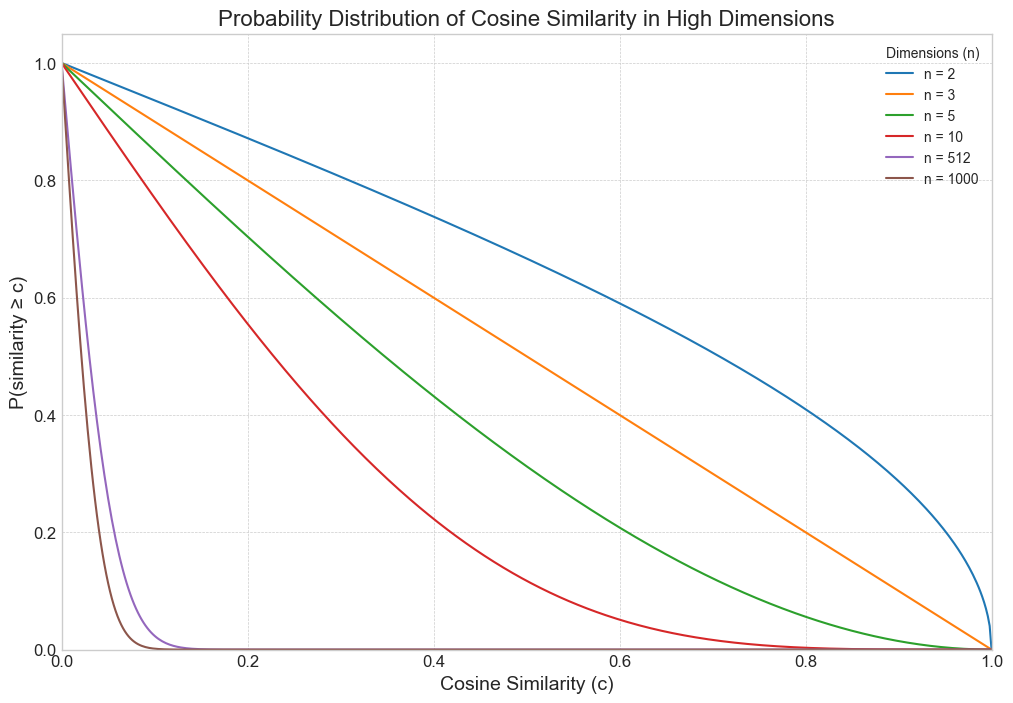

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

def plot_cosine_similarity_distribution():
    """
    Calculates and plots the complementary cumulative distribution function (CCDF)
    for cosine similarity between random vectors in various dimensions.

    This function visualizes the probability that the cosine similarity is
    greater than or equal to a certain value 'c'. This probability is
    equivalent to the ratio of the surface area of a hyperspherical cap
    to the surface area of the hemisphere.
    """
    # Set up the plot styling for better aesthetics
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # 1. Define the range of cosine similarity values from 0 to 1
    # We use a high number of points for a smooth curve.
    c = np.linspace(0, 1, 500)

    # 2. Define the different dimensions we want to visualize
    dimensions = [2, 3, 5, 10, 512, 1000]

    # 3. Calculate and plot the distribution for each dimension
    for n in dimensions:
        # The parameters 'a' and 'b' for the beta function
        a = (n - 1) / 2.0
        b = 0.5

        # The argument 'x' for the regularized incomplete beta function
        # This corresponds to sin^2(theta) where c = cos(theta)
        x = 1 - c**2

        # Calculate the probability P(similarity >= c) using the
        # regularized incomplete beta function I_x(a, b).
        # Note: scipy.special.betainc(a, b, x) is equivalent to I_x(a, b)
        probability = betainc(a, b, x)

        # Plot the result
        ax.plot(c, probability, label=f'n = {n}')

    # 4. Configure the plot with labels, title, and legend
    ax.set_xlabel('Cosine Similarity (c)', fontsize=14)
    ax.set_ylabel('P(similarity ≥ c)', fontsize=14)
    ax.set_title('Probability Distribution of Cosine Similarity in High Dimensions', fontsize=16)
    ax.legend(title='Dimensions (n)', fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set plot limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)

    # Improve tick label readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Display the plot
    plt.show()

# Run the function to generate the plot
plot_cosine_similarity_distribution()


In [ ]:
torch.save(dataset.v, f"max_norm_v_59.pth")
torch.save(dataset.y, f"max_norm_y_59.pth")
torch.save(dataset.n, f"max_norm_n_59.pth")

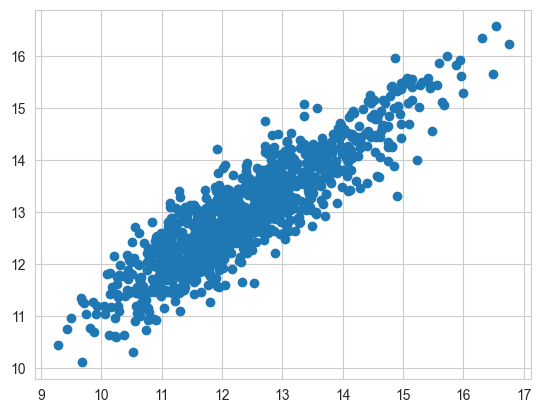

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
w_avg = G.mapping.w_avg
with torch.no_grad() and G_context(G):
    w_test = sample_w(1024, truncation_psi=1)
    w_test_centered = w_test - w_avg
    w_test_norms = torch.norm(w_test_centered, p=2, dim=1)
    w_test_directions = w_test_centered / (w_test_norms.unsqueeze(1))

    net.eval()
    targets, w_test_directions = dataset.y[100:1124], dataset.v[100:1124]
    predictions = net(w_test_directions)


    plt.scatter(targets.detach().cpu().numpy().flatten(), predictions.detach().cpu().numpy().flatten())
    plt.show()




17.170900344848633 10.418537139892578


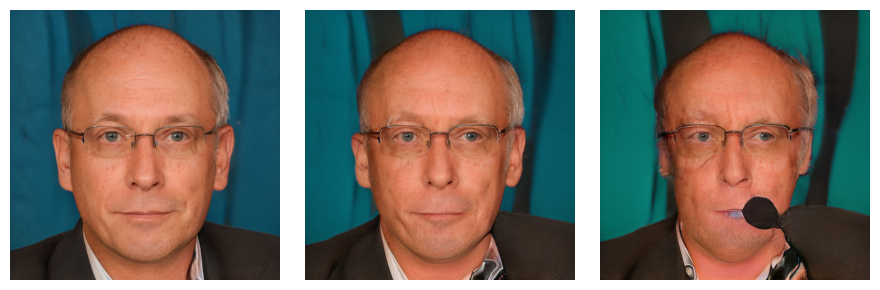

In [ ]:
with torch.no_grad() and G_context(G):
    w_test = sample_w(5, truncation_psi=1)
    w_centered = w_test - w_avg
    i = 4
    pred1, pred2 = net(w_centered[i:i+1]/w_centered[i:i+1].norm(dim=1, keepdim=True)).item(), w_centered[i:i+1].norm(dim=1, keepdim=True).item()
    print(pred1, pred2)
    show_faces([w_test[i] + j*w_centered[i] for j in np.linspace(0, (pred1-pred2)/pred2, 3)], is_w=True)









# w_test = torch.load("w_ktora_pokazuje_jak_pogiety_jest_manifold.pth")

iter    0 | loss 0.0846
iter  200 | loss -12.1321
iter  400 | loss -12.1321
iter  600 | loss -12.1321
iter  800 | loss -12.1321
iter 1000 | loss -12.1321
iter 1200 | loss -12.1321
iter 1400 | loss -12.1321
iter 1600 | loss -12.1321
iter 1800 | loss -12.1321
iter 1999 | loss -12.1321


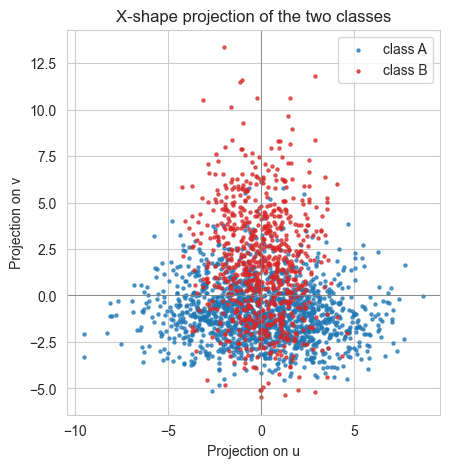


Direction u (long axis for class A)  →  tensor shape: torch.Size([512])
Direction v (long axis for class B)  →  tensor shape: torch.Size([512])


In [ ]:
# # torch.save(w_test, "w_ktora_pokazuje_jak_pogiety_jest_manifold.pth")

# with torch.no_grad() and G_context(G):
#     ws = sample_w(1024*16, truncation_psi=1)
#     ys = ALL_MODELS["trustworthy"](ws)

# m,sts = ys.mean(), ys.std()
# ws_high = ws[ys.flatten()>m+1.5*sts]
# ws_low = ws[ys.flatten()<m-1.5*sts]

# ----------------------------------------------------------------------------------
#  Discover two orthonormal 512-D directions that give an “X”-shaped 2-D view
#  – one arm per class, crossing at the common centroid.
#  Works on Apple Silicon → uses 'mps' if available, otherwise CPU.
# ----------------------------------------------------------------------------------
import torch, math, matplotlib.pyplot as plt

# ─────────────────────────────── 1 · DATA ─────────────────────────────────────────
# TODO: load your latent points here  (torch.float32 / float64)
X1 = ws_low   # class A   –  tensor [n₁, 512]
X2 = ws_high   # class B   –  tensor [n₂, 512]

# ─────────────────────────── 2 · DEVICE & CENTRING ────────────────────────────────
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
X1, X2 = X1.to(device), X2.to(device)

μ  = torch.cat([X1, X2]).mean(0, keepdim=True)
X1c, X2c = X1 - μ, X2 - μ

# ───────────────────────────── 3 · VARIABLES ──────────────────────────────────────
a = torch.randn(512, device=device, requires_grad=True)
b = torch.randn(512, device=device, requires_grad=True)

def orthonormal(a, b):
    """Return two orthonormal vectors on the unit sphere."""
    u = torch.nn.functional.normalize(a, dim=0)
    b_ortho = b - (u @ b) * u
    v = torch.nn.functional.normalize(b_ortho, dim=0)
    return u, v

# ───────────────────────────── 4 · OPTIMISATION ───────────────────────────────────
λ, β        = 1.0, 1e-2                      # hyper-parameters (see write-up)
optim       = torch.optim.Adam([a, b], lr=5e-2)
steps       = 2_000                          # tweak if you like

for it in range(steps):
    u, v = orthonormal(a, b)

    p1_u, p1_v = X1c @ u, X1c @ v
    p2_u, p2_v = X2c @ u, X2c @ v

    loss = -(p1_u.var() + p2_v.var()) + λ * (p1_v.var() + p2_u.var()) \
           + β * (p1_v.mean().pow(2) + p2_u.mean().pow(2))

    loss.backward()
    optim.step(); optim.zero_grad()

    if it % 200 == 0 or it == steps-1:
        print(f"iter {it:4d} | loss {loss.item():.4f}")

u_opt, v_opt = orthonormal(a, b)             # final orthonormal directions

# ───────────────────────────── 5 · VISUAL CHECK ───────────────────────────────────
with torch.no_grad():
    x1_u, x1_v = (X1c @ u_opt).cpu(), (X1c @ v_opt).cpu()
    x2_u, x2_v = (X2c @ u_opt).cpu(), (X2c @ v_opt).cpu()

plt.figure(figsize=(5,5))
plt.scatter(x1_u, x1_v, s=5, c='tab:blue', alpha=.7, label='class A')
plt.scatter(x2_u, x2_v, s=5, c='tab:red',  alpha=.7, label='class B')
plt.axhline(0, c='grey', lw=.6); plt.axvline(0, c='grey', lw=.6)
plt.gca().set_aspect('equal')
plt.xlabel("Projection on u"); plt.ylabel("Projection on v")
plt.title("X-shape projection of the two classes"); plt.legend()
plt.show()

# ───────────────────────────── 6 · RESULTS ────────────────────────────────────────
print("\nDirection u (long axis for class A)  →  tensor shape:", u_opt.shape)
print("Direction v (long axis for class B)  →  tensor shape:", v_opt.shape)


iter    0 | loss 6.9813
iter  200 | loss -2.0025
iter  400 | loss -7.1730
iter  600 | loss -39.4907
iter  800 | loss -85.2425
iter 1000 | loss -97.3531
iter 1200 | loss -99.5600
iter 1400 | loss -100.2551
iter 1600 | loss -100.7385
iter 1800 | loss -101.1682
iter 1999 | loss -101.5811


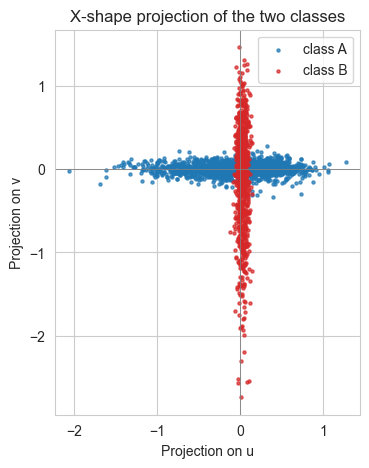


Direction u (long axis for class A)  →  tensor shape: torch.Size([512])
Direction v (long axis for class B)  →  tensor shape: torch.Size([512])
CPU times: user 8.58 s, sys: 15.7 s, total: 24.3 s
Wall time: 17.7 s


In [ ]:
%%time
# ----------------------------------------------------------------------------------
#  Discover two orthonormal 512-D directions that give an “X”-shaped 2-D view
#  – one arm per class, crossing at the common centroid.
#  Works on Apple Silicon → uses 'mps' if available, otherwise CPU.
# ----------------------------------------------------------------------------------
import torch, math, matplotlib.pyplot as plt

# ─────────────────────────────── 1 · DATA ─────────────────────────────────────────
# TODO: load your latent points here  (torch.float32 / float64)

# ─────────────────────────── 2 · DEVICE & CENTRING ────────────────────────────────
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
X1, X2 = X1.to(device), X2.to(device)

μ  = w_avg
X1c, X2c = X1 - μ, X2 - μ

# ───────────────────────────── 3 · VARIABLES ──────────────────────────────────────
a = torch.randn(512, device=device, requires_grad=True)
b = torch.randn(512, device=device, requires_grad=True)
c = torch.randn(512, device=device, requires_grad=True)
def orthonormal(a, b, c):
    """Return two orthonormal vectors on the unit sphere."""
    u = torch.nn.functional.normalize(a, dim=0)
    # b_ortho = b - (u @ b) * u
    v = torch.nn.functional.normalize(b, dim=0)
    w = torch.nn.functional.normalize(c, dim=0)
    return u, v, w

# ───────────────────────────── 4 · OPTIMISATION ───────────────────────────────────
λ, β        = 1.0, 1e2                      # hyper-parameters (see write-up)
optim       = torch.optim.Adam([a, b], lr=5e-3)
steps       = 2_000                          # tweak if you like

for it in range(steps):
    u, v, w = orthonormal(a, b, c)

    p1_u, p1_v, p1_w = X1c @ u, X1c @ v, X1c @ w
    p2_u, p2_v, p2_w = X2c @ u, X2c @ v, X2c @ w


    loss = -((p1_u.var()/p2_u.var())*(p2_v.var()/p1_v.var()))**0.5 \
           + β * ((p1_v.mean()-p2_v.mean()).pow(2) + (p1_u.mean()-p2_u.mean()).pow(2)) - 5*(p1_w.mean()-p2_w.mean())**2 +(p1_w.var()**2+p2_w.var()**2)*10

    loss.backward()
    optim.step(); optim.zero_grad()

    if it % 200 == 0 or it == steps-1:
        print(f"iter {it:4d} | loss {loss.item():.4f}")

u_opt, v_opt, w_opt = orthonormal(a, b, c)             # final orthonormal directions

# ───────────────────────────── 5 · VISUAL CHECK ───────────────────────────────────
with torch.no_grad():
    x1_u, x1_v, x1_w = (X1c @ u_opt).cpu(), (X1c @ v_opt).cpu(), (X1c @ w_opt).cpu()
    x2_u, x2_v, x2_w = (X2c @ u_opt).cpu(), (X2c @ v_opt).cpu(), (X2c @ w_opt).cpu()

plt.figure(figsize=(5,5))
plt.scatter(x1_u, x1_v, s=5, c='tab:blue', alpha=.7, label='class A')
plt.scatter(x2_u, x2_v, s=5, c='tab:red',  alpha=.7, label='class B')
plt.axhline(0, c='grey', lw=.6); plt.axvline(0, c='grey', lw=.6)
plt.gca().set_aspect('equal')
plt.xlabel("Projection on u"); plt.ylabel("Projection on v")
plt.title("X-shape projection of the two classes"); plt.legend()
plt.show()

# ───────────────────────────── 6 · RESULTS ────────────────────────────────────────
print("\nDirection u (long axis for class A)  →  tensor shape:", u_opt.shape)
print("Direction v (long axis for class B)  →  tensor shape:", v_opt.shape)

In [ ]:
mean_x1, mean_x2 = X1.mean(0), X2.mean(0)
v_to_x1, v_to_x2 = (X1-w_avg).mean(0), (X2-w_avg).mean(0)
torch.cosine_similarity(v_to_x1.view(1, -1), v_to_x2.view(1, -1))
torch.cosine_similarity(v_to_x1.view(1, -1)-v_to_x2.view(1, -1), w.view(1, -1))
# logistic

tensor([-0.0016], device='mps:0', grad_fn=<SumBackward1>)

In [ ]:
# %%time
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
#  THREE-AXIS "X" PROJECTION with PLOTLY ─ geared for Apple Silicon ('mps')
#      – u :  argmax  Var₁ / Var₂
#      – v :  argmax  Var₂ / Var₁  (subject to v ⟂ u)
#      – w :  completes the orthonormal frame, then we push the two class means
#             apart along it so the 3-D view is nicely stretched.
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
import torch, plotly.graph_objects as go
import numpy as np, math, textwrap, matplotlib.pyplot as plt

# ────────────────────────── 1 · LOAD / PREP DATA ────────────────────────────
#   X1, X2   :  tensors  [n₁, 512] , [n₂, 512]
#   w_avg    :  "global average W" from StyleGAN etc. – used as crossing point
# ---------------------------------------------------------------------------
# TODO ─ put your own tensors here ↓↓↓ (must be float32 *or* float64)
X1 =   ws_low                       # class A
X2 = ws_high                         # class B
w_avg = G.mapping.w_avg                      #        (shape [512] or [1,512])
# ---------------------------------------------------------------------------

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
X1, X2, w_avg = X1.to(device), X2.to(device), w_avg.to(device)

# centre clouds so arms cross at the shared centroid (≃w_avg)
μ  = w_avg if w_avg.ndim == 2 else w_avg.unsqueeze(0)
X1c, X2c = X1 - μ, X2 - μ

# convenience: unbiased covariance (tiny ridge makes it SPD)
def cov(x, eps=1e-5):
    n = x.shape[0]
    C = (x.T @ x) / (n - 1)
    C += eps * torch.trace(C) / C.shape[0] * torch.eye(C.shape[0], device=x.device)
    return C

Σ1, Σ2 = cov(X1c), cov(X2c)

# ─────────────────────── 2 · CLOSED-FORM u & v (eigen tricks) ───────────────
u, v, w = u, v, w
# ─────────────────────── 3 · OPTIONAL w via quick optim ─────────────────────
#  We want a vector orthogonal to (u,v) that best separates the two centroids.
with torch.no_grad():
    m1, m2 = X1c.mean(0), X2c.mean(0)
    c_raw  = m1 - m2                           # points from class means apart
    c_ort  = c_raw - (u @ c_raw)*u - (v @ c_raw)*v
    # if c_raw is (almost) in the uv-plane, fall back to random
    if torch.linalg.norm(c_ort) < 1e-6:
        c_ort = torch.randn_like(c_raw)
w = torch.nn.functional.normalize(c_ort, dim=0)

# sanity
# assert abs(u @ v) < 1e-6 and abs(u @ w) < 1e-6 and abs(v @ w) < 1e-6

# ─────────────────────── 4 · PROJECT & MOVE TO CPU ⭣ ─────────────────────────
with torch.no_grad():
    p1_u, p1_v, p1_w = (X1c @ u).cpu(), (X1c @ v).cpu(), (X1c @ w).cpu()
    p2_u, p2_v, p2_w = (X2c @ u).cpu(), (X2c @ v).cpu(), (X2c @ w).cpu()

# concatenate for Plotly -- easier to keep colours consistent
xyz     = np.stack([ torch.cat([p1_u,p2_u]),
                     torch.cat([p1_v,p2_v]),
                     torch.cat([p1_w,p2_w]) ], axis=1)
labels  = np.array(['A']*len(p1_u) + ['B']*len(p1_v))

# colour palette (feel free to tweak)
col_map = {'A':'#1f77b4', 'B':'#d62728'}
colors  = [col_map[l] for l in labels]

# ─────────────────────── 5 · 3-D SCATTER WITH PLOTLY ─────────────────────────
fig = go.Figure(layout=go.Layout(height=1000, width=1000), data=go.Scatter3d(
        x=xyz[:,0], y=xyz[:,1], z=xyz[:,2],
        mode='markers',
        marker=dict(size=4, color=colors, opacity=0.75),
        text=labels, hovertemplate='class: %{text}<br>u=%{x:.2f}<br>v=%{y:.2f}<br>w=%{z:.2f}'
    ))

fig.update_layout(
    title='Latent space projected on (u,v,w)',
    scene=dict(
        xaxis_title='u  (Var₁≫Var₂)',
        yaxis_title='v  (Var₂≫Var₁)',
        zaxis_title='w  (means separated)',
        aspectmode='cube',
        camera_eye=dict(x=1.4, y=-1.6, z=0.9)
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend_title='class'
)
fig.show()

# ─────────────────────── 6 · LITTLE REPORT ──────────────────────────────────
def ratio(dir_main, dir_other, cls_main, cls_other):
    return float(((cls_main @ dir_main).var() / (cls_other @ dir_main).var()).cpu())

print(textwrap.dedent(f"""
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
      u  maximises  Var₁/Var₂ :  ratio = {ratio(u,v,X1c,X2c):8.2f}
      v  maximises  Var₂/Var₁ :  ratio = {ratio(v,u,X2c,X1c):8.2f}
      |u·v| = {abs(u@v):.3e}   |u·w| = {abs(u@w):.3e}   |v·w| = {abs(v@w):.3e}
    ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
"""))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
  u  maximises  Var₁/Var₂ :  ratio =   127.48
  v  maximises  Var₂/Var₁ :  ratio =    85.66
  |u·v| = 4.481e-02   |u·w| = 9.214e-04   |v·w| = 7.763e-04
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛



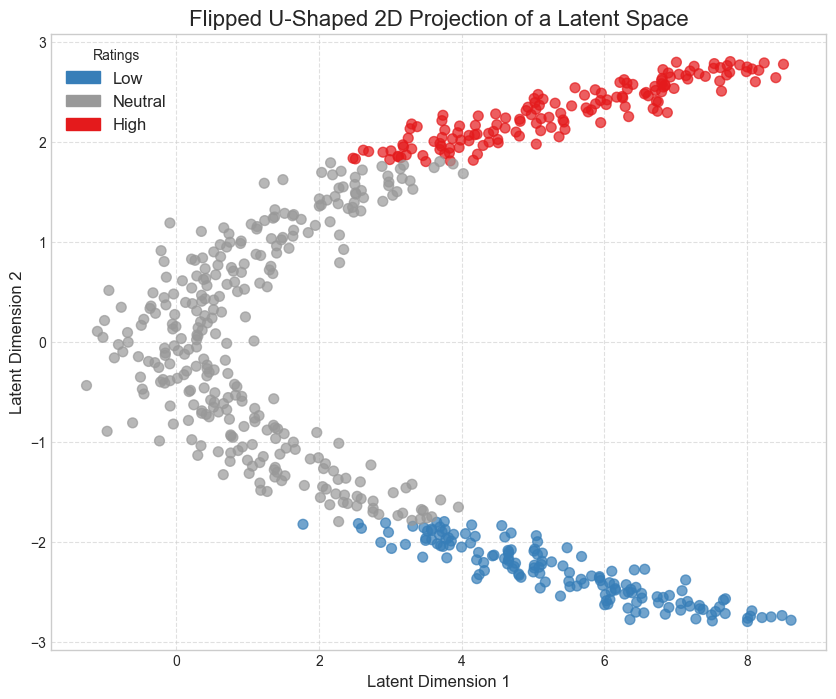

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Data Generation ---
# We generate data in three distinct segments to assign ratings easily.
# The core shape is a parabola (y = x^2) to create the "U" form.

# High-rated points
n_high = 150
x_high = np.linspace(1.8, 2.8, n_high)
y_high = x_high**2 + np.random.normal(0, 0.6, n_high)
ratings_high = ['high'] * n_high

# Low-rated points
n_low = 150
x_low = np.linspace(-2.8, -1.8, n_low)
y_low = x_low**2 + np.random.normal(0, 0.6, n_low)
ratings_low = ['low'] * n_low

# Neutral-rated points (the curve of the "U")
n_neutral = 300
x_neutral = np.linspace(-1.8, 1.8, n_neutral)
y_neutral = x_neutral**2 + np.random.normal(0, 0.6, n_neutral)
ratings_neutral = ['neutral'] * n_neutral

# --- Data Aggregation and Transformation ---
# Combine the segments into a single dataset
x_combined = np.concatenate([x_high, x_low, x_neutral])
y_combined = np.concatenate([y_high, y_low, y_neutral])
ratings_combined = np.concatenate([ratings_high, ratings_low, ratings_neutral])

# Flip the U-shape 90 degrees by swapping the x and y axes
x_flipped = y_combined
y_flipped = x_combined

# --- Plotting ---
# Define colors for each rating category
color_map = {'low': '#377eb8', 'neutral': '#999999', 'high': '#e41a1c'}
point_colors = [color_map[rating] for rating in ratings_combined]

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x_flipped, y_flipped, c=point_colors, s=50, alpha=0.7)

# --- Legend and Labels ---
# Create custom legend handles
legend_handles = [
    mpatches.Patch(color=color_map['low'], label='Low'),
    mpatches.Patch(color=color_map['neutral'], label='Neutral'),
    mpatches.Patch(color=color_map['high'], label='High')
]
plt.legend(handles=legend_handles, title="Ratings", fontsize=12)

# Set plot title and axis labels
plt.title('Flipped U-Shaped 2D Projection of a Latent Space', fontsize=16)
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

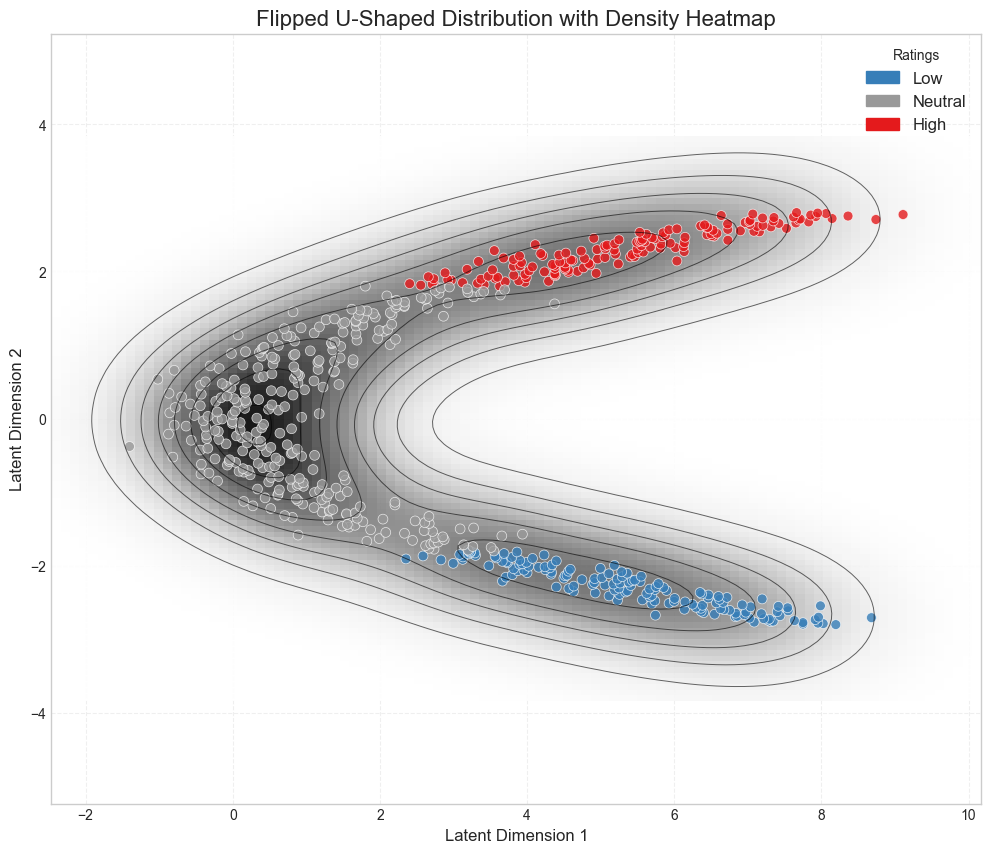

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde

# --- Data Generation ---
# This part remains the same.
n_high = 150
x_high = np.linspace(1.8, 2.8, n_high)
y_high = x_high**2 + np.random.normal(0, 0.6, n_high)
ratings_high = ['high'] * n_high

n_low = 150
x_low = np.linspace(-2.8, -1.8, n_low)
y_low = x_low**2 + np.random.normal(0, 0.6, n_low)
ratings_low = ['low'] * n_low

n_neutral = 300
x_neutral = np.linspace(-1.8, 1.8, n_neutral)
y_neutral = x_neutral**2 + np.random.normal(0, 0.6, n_neutral)
ratings_neutral = ['neutral'] * n_neutral

# --- Data Aggregation and Transformation ---
# This part also remains the same.
x_combined = np.concatenate([x_high, x_low, x_neutral])
y_combined = np.concatenate([y_high, y_low, y_neutral])
ratings_combined = np.concatenate([ratings_high, ratings_low, ratings_neutral])

x_flipped = y_combined
y_flipped = x_combined

# --- Kernel Density Estimation (NEW SECTION) ---
# We estimate the underlying probability density from the sample points.
# Stack the x and y data for the KDE
xy_kde = np.vstack([x_flipped, y_flipped])

# Perform the kernel density estimate using scipy's gaussian_kde
kde = gaussian_kde(xy_kde)

# Create a regular grid of points to evaluate the KDE on
x_grid = np.linspace(x_flipped.min() - 1, x_flipped.max() + 1, 100)
y_grid = np.linspace(y_flipped.min() - 1, y_flipped.max() + 1, 100)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_positions = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate the KDE on the grid
z = np.reshape(kde(grid_positions).T, xx.shape)


# --- Plotting ---
# Define colors for each rating category
color_map = {'low': '#377eb8', 'neutral': '#999999', 'high': '#e41a1c'}
point_colors = [color_map[rating] for rating in ratings_combined]

# Create the figure
plt.figure(figsize=(12, 10))

# Plot the density heatmap in the background
plt.pcolormesh(xx, yy, z, cmap='Greys', shading='auto', alpha=0.9)

# Plot the density contours on top of the heatmap
plt.contour(xx, yy, z, levels=8, colors='black', linewidths=0.7, alpha=0.6)

# Plot the original scatter points on top of the density plot
plt.scatter(x_flipped, y_flipped, c=point_colors, s=50, alpha=0.8, edgecolors='w', linewidth=0.5)

# --- Legend and Labels ---
# Create custom legend handles
legend_handles = [
    mpatches.Patch(color=color_map['low'], label='Low'),
    mpatches.Patch(color=color_map['neutral'], label='Neutral'),
    mpatches.Patch(color=color_map['high'], label='High')
]
plt.legend(handles=legend_handles, title="Ratings", fontsize=12)

# Set plot title and axis labels
plt.title('Flipped U-Shaped Distribution with Density Heatmap', fontsize=16)
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal') # Ensure aspect ratio is equal
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go

# --- Data Generation (Similar to before) ---
# We generate the base U-shape and ratings.
n_high = 150
x_high = np.linspace(1.8, 2.8, n_high)
y_high = 3*x_high**2 + np.random.normal(0, 1.6, n_high)
ratings_high = ['high'] * n_high

n_low = 150
x_low = np.linspace(-2.8, -1.8, n_low)
y_low = 3*x_low**2 + np.random.normal(0, 1.6, n_low)
ratings_low = ['low'] * n_low

n_neutral = 300
x_neutral = np.linspace(-1.8, 1.8, n_neutral)
y_neutral = 3*x_neutral**2 + np.random.normal(0, 1.6, n_neutral)
ratings_neutral = ['neutral'] * n_neutral

# --- Data Aggregation and Transformation into 3D ---
# Combine the segments
x_combined = np.concatenate([x_high, x_low, x_neutral])
y_combined = np.concatenate([y_high, y_low, y_neutral])
ratings_combined = np.concatenate([ratings_high, ratings_low, ratings_neutral])

# Create the 2D flipped U-shape coordinates (this is our X-Y plane)
x_3d = y_combined
y_3d = x_combined

# --- Create the 3rd Dimension (Z) ---
# The z-coordinate is based on the position along the U-curve (y_3d).
# This makes the distribution rise as the rating increases from low to high.
# The scale factor "stretches" the spiral vertically.
z_scale_factor = 8
z_3d = (np.sin(y_3d*1.5)+ np.random.normal(0, .2, len(y_3d))) * z_scale_factor 


# --- Plotting with Plotly ---
# Define colors for each rating category
color_map = {'low': '#377eb8', 'neutral': '#999999', 'high': '#e41a1c'} |{'neutral': 'white'}
point_colors = [color_map[rating] for rating in ratings_combined]

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x_3d,
    y=y_3d,
    z=z_3d,
    mode='markers',
    marker=dict(
        size=4,
        color=point_colors,  # Set color to the rating-based colors
        opacity=0.8,
        colorbar=dict(title="Rating"), # This won't show with direct colors, but good practice
    )
)], layout=go.Layout(height=1000))

# Update the layout for a clean look
fig.update_layout(
    title='3D Spiral Distribution in Latent Space',
    scene=dict(
        xaxis_title='Latent Dimension 1',
        yaxis_title='Latent Dimension 2',
        zaxis_title='Latent Dimension 3 (Rating Correlated)',
        # Set aspect ratio to make the spiral visually clear
        aspectratio=dict(x=1, y=1, z=0.8),
        camera_eye=dict(x=1.2, y=-1.8, z=0.5) # Set an initial viewing angle
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  1.,  1.,  2.,  0.,  0.,  0.,  2.,  1.,  3.,  0.,
         1.,  0.,  6.,  2.,  1.,  3.,  0.,  2.,  2.,  1.,  4.,  6.,  2.,
         2.,  2.,  4., 11., 10.,  7.,  7.,  9.,  7., 11., 16., 22., 13.,
        21., 17., 20., 19., 28., 30., 34., 38., 36., 30., 33., 30., 22.,
        17., 17., 15., 18., 19., 12., 32., 26., 20., 20., 25., 24., 15.,
         7., 10., 10., 11.,  6., 11., 11.,  6., 11.,  5.,  6., 10., 10.,
        13.,  7.,  9., 14.,  9.,  9., 15., 10., 16.]),
 array([16.42472458, 16.46513367, 16.50554276, 16.54595184, 16.58636093,
        16.62677002, 16.66718102, 16.7075901 , 16.74799919, 16.78840828,
        16.82881737, 16.86922646, 16.90963554, 16.95004463, 16.99045372,
        17.03086281, 17.0712719 , 17.11168289, 17.15209198, 17.19250107,
        17.23291016, 17.27331924, 17.31372833, 17.35413742, 17.39454651,
        17.4349556 , 17.47536469, 17.51577377, 17.55618286, 17.596593

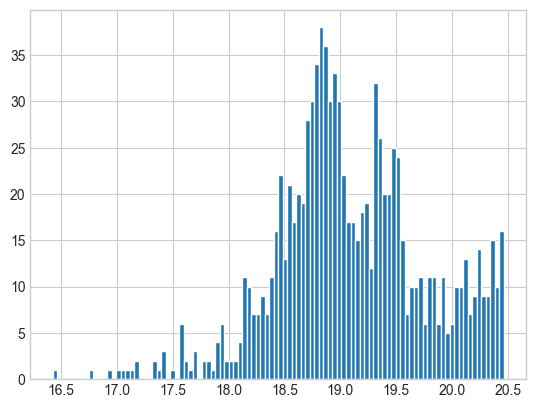

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

print("Dataset prepared. Pre-calculated norms and directions.")



# --- 5. Training ---
model = MaxNormPredictor(input_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print("\nStarting model training...")
for step in tqdm(range(TRAINING_STEPS)):
    # 1. Generate a batch of random direction vectors for training
    # Sample from a standard normal distribution and normalize
    random_vectors = torch.randn(BATCH_SIZE, LATENT_DIM, device=DEVICE)
    direction_batch = random_vectors / (torch.norm(random_vectors, dim=1, keepdim=True) + 1e-9)

    # targets = calculate_local_direction_max_norm_target(direction_batch, w_directions, w_norms, .1).unsqueeze(1)
    targets = predict_max_by_shell_weighting(direction_batch, w_directions, w_norms, c_threshold=0.1).unsqueeze(1)

    # 3. Forward pass, loss calculation, and backpropagation
    model.train()
    optimizer.zero_grad()
    
    predictions = model(direction_batch)
    loss = criterion(predictions, targets)
    
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"Step {step}/{TRAINING_STEPS}, Loss: {loss.item():.4f}")

print("Training complete.")

# --- 6. Example Usage ---
print("\n--- Testing with a random direction vector ---")
model.eval()

This code learns to predict the magnitude of the data distribution given a direction. Assume all of the variables and functions involved are defined. Do not write them. Instead, rewrite this training and model architecture using first principles as to how to encode direction for neural network training. You can consider some transformer-like architectures which use dot products inherently to encode the direction better and make the training more sophisticated, add cosign scheduling and so on. And so on.


In [ ]:
import torch
import torch.nn.functional as F

def predict_y_kernel_regression(
    v_test: torch.Tensor,
    v_dataset: torch.Tensor,
    y_dataset: torch.Tensor,
    n: int
) -> torch.Tensor:
    """
    Predicts the value 'y' for a test vector using kernel regression on a hypersphere.

    This function calculates the expected value of y for a test vector by performing
    a weighted average of known y-values from a dataset. The weights are determined
    by the cosine similarity between the test vector and the dataset vectors, passed
    through a dimension-aware von Mises-Fisher kernel.

    Args:
        v_test (torch.Tensor): The normalized test vector for which to predict y.
                               Shape: (D,) where D is the feature dimension.
        v_dataset (torch.Tensor): The normalized vectors from the dataset.
                                  Shape: (N, D) where N is the number of samples.
        y_dataset (torch.Tensor): The corresponding 'y' values for each vector
                                  in the dataset. Shape: (N,).
        n (int): The dimensionality of the vector space (D). This is used as the
                 concentration parameter 'kappa' for the kernel, making the
                 weighting "dimensionally-aware".

    Returns:
        torch.Tensor: The predicted 'y' value, a scalar tensor.
    """
    # Ensure input tensors are on the same device (e.g., 'cuda' or 'cpu')
    device = v_dataset.device
    v_test = v_test.to(device)
    y_dataset = y_dataset.to(device)

    # --- Step 1: Calculate Cosine Similarities ---
    # This is a highly efficient way to compute cosine similarity for one vector
    # against a batch of vectors. We assume vectors are already normalized.
    # The result 'c' will be a tensor of shape (N,).
    c = F.linear(v_test.unsqueeze(0), v_dataset).squeeze(0)

    # Clamp the values to avoid potential floating point inaccuracies outside [-1, 1]
    c = torch.clamp(c, -1.0, 1.0)

    # --- Step 2 & 3: Apply Kernel and Normalize (Softmax) ---
    # We use the dimension 'n' as the concentration parameter 'kappa'.
    # A higher 'n' leads to a 'sharper' kernel, focusing more on very
    # similar vectors, which is what's needed in high dimensions.
    # The 'logits' for the softmax are simply kappa * cosine_similarity.
    kappa = float(n)
    logits = kappa * c

    # The softmax function computes exp(logits) / sum(exp(logits)), which is
    # exactly the normalized kernel weights we need.
    # The weights will be a tensor of shape (N,).
    weights = F.softmax(logits, dim=0)

    # --- Step 4: Compute the Weighted Average ---
    # Perform a dot product between the weights and the y-values.
    y_predicted = torch.dot(weights, y_dataset)

    return y_predicted

# --- Example Usage ---
if __name__ == '__main__':
    # Define problem parameters
    num_samples = 1000
    dimensionality = 128  # Our 'n'

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create a synthetic dataset
    # Dataset vectors (already normalized)
    v_dataset = F.normalize(torch.randn(num_samples, dimensionality, device=device), p=2, dim=1)

    # Let's create synthetic y-values that are correlated with the first dimension
    # to make the problem meaningful.
    y_dataset = v_dataset[:, 0] * 10 + torch.randn(num_samples, device=device) * 0.5

    # Create a test vector
    v_test = F.normalize(torch.randn(dimensionality, device=device), p=2, dim=0)

    # Predict the y-value for the test vector
    y_pred = predict_y_kernel_regression(v_test, v_dataset, y_dataset, n=dimensionality)

    print(f"\nTest vector's first dimension: {v_test[0].item():.4f}")
    print(f"Predicted y value: {y_pred.item():.4f}")

    # For comparison, let's see the y-value of the most similar vector in the dataset
    similarities = F.linear(v_test.unsqueeze(0), v_dataset).squeeze(0)
    most_similar_idx = torch.argmax(similarities)
    print(f"Most similar vector's y-value: {y_dataset[most_similar_idx].item():.4f}")
    print(f"Highest cosine similarity: {similarities[most_similar_idx].item():.4f}")


Using device: cpu

Test vector's first dimension: 0.0668
Predicted y value: 0.9270
Most similar vector's y-value: 1.0205
Highest cosine similarity: 0.2715


Using device: cpu

--- Predictions ---
Test Vector 0: Predicted Max w_ns = 1.4916
Test Vector 1: Predicted Max w_ns = 1.6204
Test Vector 2: Predicted Max w_ns = 1.7456
Test Vector 3: Predicted Max w_ns = 1.1653


Loading pre-trained trust model to be used as f(w)...
Loading trust model ensemble for dimension: trustworthy


<All keys matched successfully>

# Trustworthy

.

.

.

.

.

.



















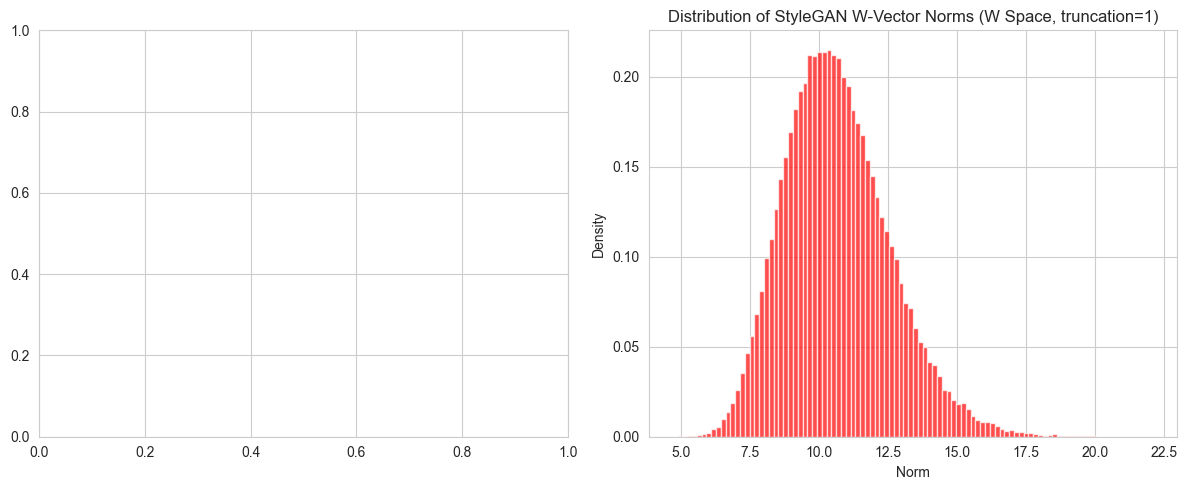

In [ ]:
w = sample_w(100000,1); w_norms = torch.norm(w, dim=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax2.hist(w_norms.cpu().numpy(), bins=100, density=True, alpha=0.7, color='red'); ax2.set_title('Distribution of StyleGAN W-Vector Norms (W Space, truncation=1)'); ax2.set_xlabel('Norm'); ax2.set_ylabel('Density')
plt.tight_layout(); plt.show()






ValueError: x and y must have same first dimension, but have shapes (100,) and (1, 100)

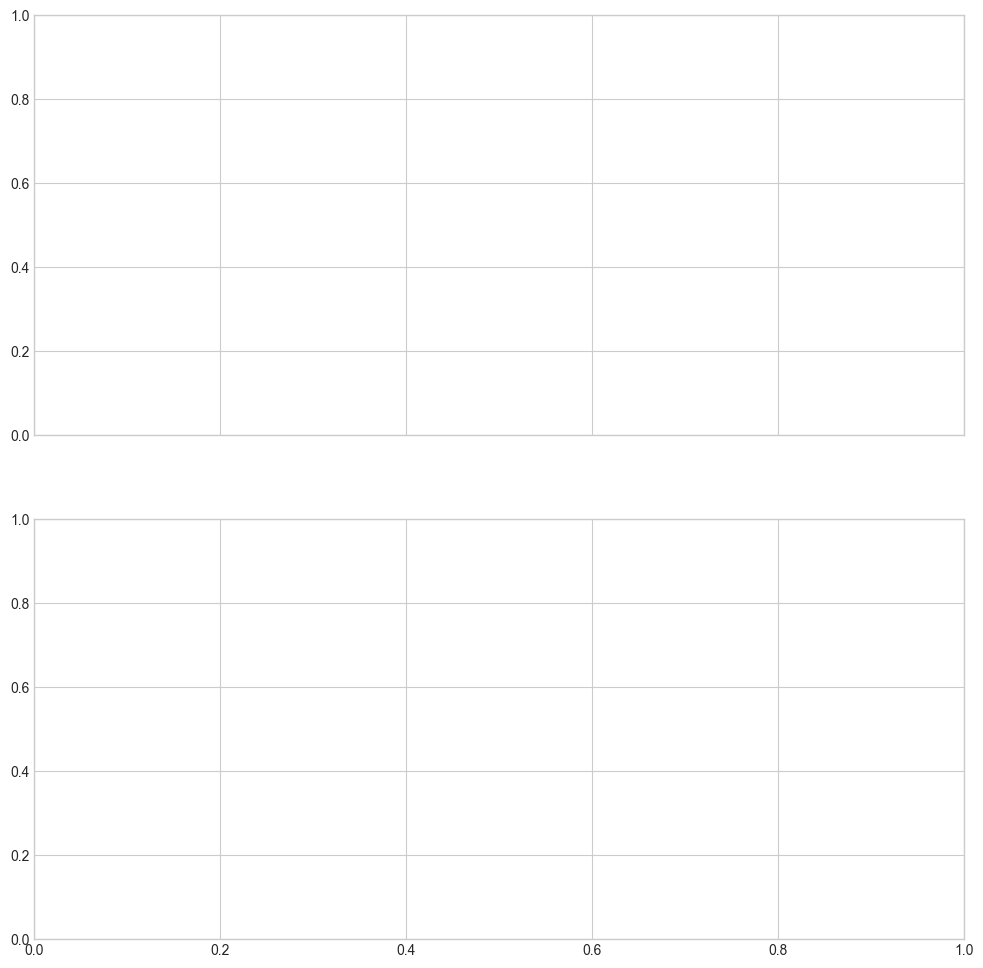

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.integrate import quad

# --- 1. Simulation Setup & Ground Truth ---

# Parameters for the psychometric potential function
A_SLOPE = 2.0  # Global linear trend
B_SINE_AMP = 1.5  # Amplitude of local non-linearity
K_SINE_FREQ = 2.0  # Frequency of local non-linearity

def psi(s):
    """True psychometric potential function."""
    return A_SLOPE * s + B_SINE_AMP * np.sin(K_SINE_FREQ * s)

def grad_psi(s):
    """True analytical gradient of the potential function."""
    return A_SLOPE + B_SINE_AMP * K_SINE_FREQ * np.cos(K_SINE_FREQ * s)

def generate_data(n_samples=2000, s_min=-5, s_max=5, noise_std=0.5):
    """Generates a dataset of stimuli and noisy ratings."""
    s_data = np.random.uniform(s_min, s_max, n_samples)
    true_ratings = psi(s_data)
    noisy_ratings = true_ratings + np.random.normal(0, noise_std, n_samples)
    return s_data, noisy_ratings

# --- 2. Kernel and Local Estimator Functions ---

def gaussian_kernel(u):
    """Standard Gaussian kernel."""
    return norm.pdf(u)

def estimate_local_ols(s_center, s_data, r_data, lambda_bw):
    """Estimates the local gradient using weighted least squares (WLS)."""
    # Calculate weights based on distance from the center point
    distances = (s_data - s_center) / lambda_bw
    weights = gaussian_kernel(distances)
    
    # Add a constant for the intercept term
    X = np.vstack([np.ones(len(s_data)), s_data]).T
    
    # Perform weighted least squares
    try:
        # WLS solution: beta = (X^T W X)^-1 X^T W y
        W = np.diag(weights)
        XTWX_inv = np.linalg.inv(X.T @ W @ X)
        XTWy = X.T @ W @ r_data
        beta = XTWX_inv @ XTWy
        return beta[1]  # Return the slope (gradient)
    except np.linalg.LinAlgError:
        return np.nan # Return NaN if matrix is singular (no points in kernel)

def estimate_local_ci(s_center, s_data, r_data, lambda_bw, n_pairs=500):
    """Estimates the local gradient using the Classification Image method."""
    # Select a local subset of data based on the kernel bandwidth
    local_indices = np.where(np.abs(s_data - s_center) < 2 * lambda_bw)[0]
    if len(local_indices) < 2:
        return np.nan

    local_s = s_data[local_indices]
    local_r = r_data[local_indices]

    # Simulate 2AFC trials by randomly pairing points from the local subset
    pair_indices_a = np.random.choice(len(local_s), n_pairs, replace=True)
    pair_indices_b = np.random.choice(len(local_s), n_pairs, replace=True)

    s_a, r_a = local_s[pair_indices_a], local_r[pair_indices_a]
    s_b, r_b = local_s[pair_indices_b], local_r[pair_indices_b]

    # Determine choice 'c' based on which rating is higher
    choices = np.sign(r_a - r_b)
    
    # Calculate stimulus differences
    s_diff = s_a - s_b
    
    # Avoid division by zero if all differences are the same
    if np.var(s_diff) == 0:
        return np.nan

    # Calculate the CI and scale it to be comparable to a gradient
    # The scaling factor is derived from the relationship between CI and regression slope
    ci_raw = np.mean(choices * s_diff)
    scaling_factor = np.var(s_diff)
    
    # For 2AFC, the effective signal is doubled, so we divide by 2
    ci_scaled = ci_raw / (scaling_factor / 2)
    
    return ci_scaled

# --- 3. Simulation and Analysis ---

def run_local_simulation(s_grid, s_data, r_data, lambda_bw):
    """Runs the local estimation over a grid of points."""
    ols_estimates = []
    ci_estimates = []
    
    # Numerically calculate the smoothed gradient (convolution with kernel)
    def integrand(s, s_center):
        return grad_psi(s) * norm.pdf((s - s_center) / lambda_bw)
    
    smoothed_gradient = [quad(integrand, -np.inf, np.inf, args=(s0,))[0] / (lambda_bw) for s0 in s_grid]

    for s0 in s_grid:
        ols_estimates.append(estimate_local_ols(s0, s_data, r_data, lambda_bw))
        ci_estimates.append(estimate_local_ci(s0, s_data, r_data, lambda_bw))
        
    return np.array(ols_estimates), np.array(ci_estimates), np.array(smoothed_gradient)

def run_global_analysis(s_data, r_data):
    """Calculates global estimators and the true average gradient."""
    # True average gradient over the data range
    true_avg_grad = quad(grad_psi, s_data.min(), s_data.max())[0] / (s_data.max() - s_data.min())
    
    # Global OLS estimator
    X = np.vstack([np.ones(len(s_data)), s_data]).T
    beta_global = np.linalg.inv(X.T @ X) @ X.T @ r_data
    global_ols_est = beta_global[1]
    
    # Global CI estimator
    median_rating = np.median(r_data)
    class_pos_s = s_data[r_data >= median_rating]
    class_neg_s = s_data[r_data < median_rating]
    global_ci_est = np.mean(class_pos_s) - np.mean(class_neg_s)
    # This CI is not scaled to a gradient, it's a difference in means.
    # We plot it to show the directional idea.
    
    return true_avg_grad, global_ols_est, global_ci_est

# --- 4. Main Execution and Plotting ---

if __name__ == '__main__':
    # Generate data
    s_data, r_data = generate_data(n_samples=4000, noise_std=1.0)
    disable_standardization = True
    def standardize(*args):
        if disable_standardization:
            return args
        """Each estimator has a different scale of the estimate that depends on the particulars of the implementation, data scaling and so on. 
        What we want to show is that these estimators agree as to the direction of the vector, the gradient vector that they estimate. 
        Thus th 1-d the analog for the multi-dimensional grad case is to show agreement as to the deviations around the mean irrespective of the scaling properties of the estimators.
        We standardize the mean and scale of the predictions to comapare them, which is the analog of the normalization of the gradient vector in the multi-dimensional case."""
        return [(x - np.mean(x)) / np.std(x) for x in args] if len(args)>1 else (args[0] - np.mean(args[0])) / np.std(args[0])
    

    def _grad_psi(s):
        return standardize(grad_psi(s))
    # Define a grid for local analysis
    s_grid = np.linspace(-4.5, 4.5, 100)
    
    # --- Run and Plot Local Analysis for two lambda values ---
    lambda_local = 0.5
    lambda_global_ish = 1.5
    
    ols_local, ci_local, smooth_local = run_local_simulation(s_grid, s_data, r_data, lambda_local)
    ols_local, ci_local, smooth_local = standardize(ols_local, ci_local, smooth_local)
    ols_global, ci_global, smooth_global = run_local_simulation(s_grid, s_data, r_data, lambda_global_ish)
    ols_global, ci_global, smooth_global = standardize(ols_global, ci_global, smooth_global)

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    
    # Plot for small lambda (local)
    axes[0].plot(s_grid, _grad_psi(s_grid), 'k-', lw=3, label='True Gradient')
    axes[0].plot(s_grid, smooth_local, 'r--', lw=2, label='Smoothed True Gradient (Target)')
    axes[0].plot(s_grid, ols_local, 'b.-', alpha=0.7, label='Local OLS Estimate')
    axes[0].plot(s_grid, ci_local, 'g.-', alpha=0.7, label='Local CI Estimate')
    axes[0].set_title(f'Local Analysis (Kernel Bandwidth $\lambda$ = {lambda_local})', fontsize=14)
    axes[0].set_ylabel('Gradient Value', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True)

    # Plot for large lambda (more global)
    axes[1].plot(s_grid, _grad_psi(s_grid), 'k-', lw=3, label='True Gradient')
    axes[1].plot(s_grid, smooth_global, 'r--', lw=2, label='Smoothed True Gradient (Target)')
    axes[1].plot(s_grid, ols_global, 'b.-', alpha=0.7, label='Local OLS Estimate')
    axes[1].plot(s_grid, ci_global, 'g.-', alpha=0.7, label='Local CI Estimate')
    axes[1].set_title(f'More Global Analysis (Kernel Bandwidth $\lambda$ = {lambda_global_ish})', fontsize=14)
    axes[1].set_xlabel('Stimulus Value (s)', fontsize=12)
    axes[1].set_ylabel('Gradient Value', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # --- Run and Plot Global Analysis ---
    true_avg, ols_glob, ci_glob = run_global_analysis(s_data, r_data)
    
    fig_bar, ax_bar = plt.subplots(figsize=(8, 6))
    labels = ['True Average Gradient', 'Global OLS Estimate', 'Global CI (Mean Diff.)']
    values = [true_avg, ols_glob, ci_glob]
    
    ax_bar.bar(labels, values, color=['black', 'blue', 'green'])
    ax_bar.set_title('Global Estimator Comparison', fontsize=14)
    ax_bar.set_ylabel('Value', fontsize=12)
    ax_bar.tick_params(axis='x', rotation=15)
    plt.tight_layout()
    plt.show()


Using device: mps

--- Predictions ---
Test Vector 0: Predicted Max w_ns = 65.1489
Test Vector 1: Predicted Max w_ns = 65.1705
Test Vector 2: Predicted Max w_ns = 66.8586
Test Vector 3: Predicted Max w_ns = 65.8795


In [ ]:
with torch.no_grad():

    test_vectors = torch.randn(10, LATENT_DIM, device=DEVICE)
    test_vectors = F.normalize(test_vectors, p=2, dim=1)

    start_time = time.time()
    predicted_max1 = predict_max_by_shell_weighting(test_vectors[:3], w_directions, w_norms, n=LATENT_DIM, c_threshold=0.01)
    print(f"Time taken: {time.time() - start_time}")
    start_time = time.time()
    print(f"Time taken: {time.time() - start_time}")
    start_time = time.time()
    predicted_max3 = predict_max_by_shell_weighting(test_vectors[:3], w_directions, w_norms, n=LATENT_DIM, c_threshold=0.15)
    print(f"Time taken: {time.time() - start_time}")
    start_time = time.time()
    predicted_max4 = predict_max_by_shell_weighting(test_vectors[:3], w_directions, w_norms, n=LATENT_DIM, c_threshold=0.8)
    print(f"Time taken: {time.time() - start_time}")
    start_time = time.time()
    predicted_max_ols = calculate_local_direction_max_norm_target(test_vectors[:3], w_directions, w_norms, .1)
torch.stack([predicted_max1,predicted_max2,predicted_max3,predicted_max4,predicted_max_ols])

NameError: name 'w_directions' is not defined

In [ ]:

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
LATENT_DIM = 512
NUM_SAMPLES = 100_000
OLS_COSINE_THRESHOLD = 0.99 # The cosine similarity threshold for including a vector in the OLS calculation.
OLS_MIN_SAMPLES = 100 # Minimum number of samples required to perform OLS.
TRAINING_STEPS = 5000
BATCH_SIZE = 128
LEARNING_RATE = 1e-4

print(f"Using device: {DEVICE}")
print("Generating initial W-space dataset...")

# --- 2. Data Preparation ---
# Generate the raw w-vectors and center them
with torch.no_grad():
    w_vectors = sample_w(NUM_SAMPLES, truncation_psi=1).to(DEVICE)
    w_avg = G.mapping.w_avg
    w_centered = w_vectors - w_avg

    # Pre-calculate norms and normalized direction vectors for efficiency
    w_norms = torch.norm(w_centered, p=2, dim=1)
    # Add a small epsilon to avoid division by zero for potential zero-vectors
    w_directions = w_centered / (w_norms.unsqueeze(1) + 1e-9)

Using device: mps
Generating initial W-space dataset...


In [ ]:
w_norms.max()

tensor(21.8666, device='mps:0')